In [36]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 7.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [37]:
from typing import Dict
import os

import torch
import torch.nn.functional as F
import torchvision
from fastprogress import progress_bar as pb
from datasets import load_dataset
import pandas as pd
import transformers
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import faiss

import warnings
warnings.simplefilter('ignore')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## Config

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SHAPE = (3, 128, 128)

# Training Config
EPOCHS = 100
TRAIN_BATCH_SIZE = 64
LR = 5e-4
WEIGHT_DECAY = 1e-1
GRAD_ACCUM_STEPS = 1

dtype = torch.float32#torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
use_amp = False
amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

## Load Tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
TEXT_PADDING_MAX_LENGTH = 3

## Prepare Dataset

In [4]:
CIFAR10_LABELS = """airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck""".split('\n')

In [5]:
hf_dataset = load_dataset(
    'uoft-cs/cifar10', trust_remote_code=True,
    # cache_dir='./cache_data'
)

In [6]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [7]:
hf_dataset_train = hf_dataset['train']
hf_dataset_test = hf_dataset['test']

In [8]:
pd.Series(hf_dataset_train['label']).value_counts().sort_index()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64

In [9]:
pd.Series(hf_dataset_test['label']).value_counts().sort_index()

0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64

In [10]:
hf_dataset_train[0]['img'].size

(32, 32)

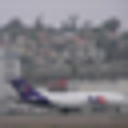

In [11]:
hf_dataset_train[0]['img'].resize((128, 128))

In [12]:
image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMG_SHAPE[-2:], interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMG_SHAPE[1:]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5]),
    ]
)

In [13]:
@torch.inference_mode()
def encode_text(texts):
    inputs = tokenizer(texts, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    return inputs

def preprocess_data(examples):
    images = [image.convert("RGB") for image in examples['img']]
    images = [image_transforms(image) for image in images]

    labels_str = [CIFAR10_LABELS[label] for label in examples['label']]
    examples["label"] = examples['label']
    examples["label_str"] = labels_str
    
    examples["pixel_values"] = images
    tokenized_inputs= encode_text(labels_str)
    examples['text_input_ids'] = tokenized_inputs['input_ids']
    examples["text_attn_mask"] = tokenized_inputs['attention_mask']

    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    text_input_ids = torch.stack([example["text_input_ids"] for example in examples])
    text_attn_mask = torch.stack([example["text_attn_mask"] for example in examples])

    labels = torch.tensor([example["label"] for example in examples]).long()

    return {
        "pixel_values": pixel_values.to(dtype),
        "text_input_ids": text_input_ids,
        'text_attn_mask': text_attn_mask,
        'label': labels,
    }

In [14]:
%%time
hf_dataset = hf_dataset.with_transform(preprocess_data)

CPU times: user 43.2 ms, sys: 229 µs, total: 43.4 ms
Wall time: 41.3 ms


In [15]:
hf_dataset['train'][0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0,
 'label_str': 'airplane',
 'pixel_values': tensor([[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1843, -0.1843, -0.1843,  ..., -0.2784, -0.2784, -0.2784],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],
 
         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2392, -0.2392, -0.2392,  ..., -0.3333, -0.3333, -0.3333],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)

In [17]:
_batch = next(iter(train_dataloader))

In [18]:
{k: v.shape for k, v in _batch.items()}

{'pixel_values': torch.Size([64, 3, 128, 128]),
 'text_input_ids': torch.Size([64, 3]),
 'text_attn_mask': torch.Size([64, 3]),
 'label': torch.Size([64])}

## Model

In [19]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisualTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisualTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        return image_features, text_features 

In [20]:
model = CLIP(
     embed_dim=256,
     # vision
     image_resolution=128,
     vision_layers=6,
     vision_width=512,
     vision_patch_size=32,
     # text
     context_length=TEXT_PADDING_MAX_LENGTH,
     vocab_size=49408,
     transformer_width=256,
     transformer_heads=8,
     transformer_layers=6,
).eval().to(device)

In [82]:
torch.save(model.state_dict(), 'tmp_clip.pt')
!ls -lh
!rm tmp_clip.pt

total 146M
-rw-r--r-- 1 root root  65K Feb  9 11:48 clip.ipynb
-rw-r--r-- 1 root root 146M Feb  9 11:48 tmp_clip.pt


In [83]:
with torch.inference_mode():
    _image_features, _text_features = model(_batch['pixel_values'].to(device), _batch['text_input_ids'].to(device))

In [84]:
_image_features.shape, _text_features.shape

(torch.Size([32, 256]), torch.Size([32, 256]))

In [20]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [25]:
model = CLIP(
     embed_dim=256,
     # vision
     image_resolution=128,
     vision_layers=6,
     vision_width=512,
     vision_patch_size=16,
     # text
     context_length=TEXT_PADDING_MAX_LENGTH,
     vocab_size=49408,
     transformer_width=256,
     transformer_heads=8,
     transformer_layers=6,
).to(device).to(dtype)
# model.load_state_dict(torch.load('./denoise_model_vaele_tmp.pt'))

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=2*len(train_dataloader),
    num_training_steps=EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device='cuda', enabled=use_amp)

In [27]:
train_loss_history = []
test_metric_hostory = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    for i, batch in enumerate(pb(train_dataloader)):
        batch = batch_to_device(batch, device)

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
            image_features, text_features = model(batch['pixel_values'], batch['text_input_ids'])
    
            # normalized features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # (bs, emb_dim)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # (bs, emb_dim)
    
            logit_scale = model.logit_scale.exp()
    
            logits_per_image = logit_scale * image_features @ text_features.t()  # (bs, bs)
            logits_per_text = logit_scale * text_features @ image_features.t()  # (bs, bs)
    
            labels = torch.arange(len(logits_per_image)).to(logits_per_image.device)
    
            image_loss = F.cross_entropy(logits_per_image, labels)
            text_loss  = F.cross_entropy(logits_per_text, labels)
    
            loss = (image_loss + text_loss) / 2
            loss = loss / GRAD_ACCUM_STEPS

        if torch.isnan(loss):
            raise Exception()
        scaler.scale(loss).backward()

        epoch_loss += loss.item()

        if (i + 1) % GRAD_ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            model.logit_scale.data = torch.clamp(model.logit_scale.data, 0, 4.6052)
            if scheduler:
                scheduler.step() 
            model.zero_grad()
    train_loss_history.append(epoch_loss / len(train_dataloader))

    model.eval()
    all_label_tokenized_input_ids = encode_text(CIFAR10_LABELS)['input_ids'].to(device)
    all_label_text_features = model.encode_text(all_label_tokenized_input_ids)  # (n_labels, emb_dim)
    all_label_text_features = all_label_text_features / all_label_text_features.norm(dim=-1, keepdim=True)

    test_pred_label_list = []
    test_true_label_list = []
    for i, batch in enumerate(pb(test_dataloader)):
        batch = batch_to_device(batch, device)

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
            image_features = model.encode_image(batch['pixel_values'])  # (bs, emb_dim)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            pred_labels = (image_features @ all_label_text_features.t()).argmax(dim=-1)  # (bs, n_labels) => (bs,)
            test_pred_label_list.append(pred_labels.cpu())
            test_true_label_list.append(batch['label'].cpu())
    test_pred_label = torch.cat(test_pred_label_list, dim=0)
    test_true_label = torch.cat(test_true_label_list, dim=0)
    test_metric_hostory.append({
        'acc': accuracy_score(test_true_label, test_pred_label),
        'blc_acc': accuracy_score(test_true_label, test_pred_label),
        'cm': confusion_matrix(test_true_label, test_pred_label),
    })

    print(f'[epoch {epoch}] train loss : {train_loss_history[-1]}')
    print(f'[epoch {epoch}] test metrics : {test_metric_hostory[-1]}')

[epoch 0] train loss : 3.4881192927470295
[epoch 0] test metrics : {'acc': 0.4506, 'blc_acc': 0.4506, 'cm': array([[717,  23, 117,  20,  27,   2,  16,   4,  62,  12],
       [192, 423,  43,  30,  21,   2,  33,  18,  73, 165],
       [104,  15, 486,  84, 103,  17, 153,  15,  18,   5],
       [ 36,  13, 204, 397, 118,  59, 120,  26,  20,   7],
       [ 52,   4, 236,  83, 447,   7, 136,  19,  13,   3],
       [ 33,  16, 257, 298, 155, 139,  35,  36,  28,   3],
       [ 16,   4,  94,  98,  83,   8, 685,   7,   3,   2],
       [ 56,  11,  98,  66, 397,  20,  15, 305,  14,  18],
       [376,  32,  31,  14,  22,   0,  13,   4, 483,  25],
       [152,  98,  32,  41,  56,   3,  18,  43, 133, 424]])}


[epoch 1] train loss : 3.283633681514379
[epoch 1] test metrics : {'acc': 0.4492, 'blc_acc': 0.4492, 'cm': array([[469, 120,  42,  24,   3,   6,  35,   7, 251,  43],
       [ 52, 796,   1,   4,   1,   0,  10,   4,  92,  40],
       [ 86,  77, 227,  56, 112,  65, 214,  28, 115,  20],
       [ 18, 131,  64, 227,  33, 152, 191,  43,  91,  50],
       [ 37,  58,  85,  55, 348,  37, 184,  72,  80,  44],
       [ 12,  94, 103, 175,  73, 283, 106,  55,  63,  36],
       [ 11,  52,  51,  76,  56,  16, 681,  11,  30,  16],
       [ 34,  97,  46,  53,  86,  64,  36, 427,  48, 109],
       [ 91,  77,  10,  10,   2,   5,  10,   1, 755,  39],
       [ 41, 501,   5,  11,   2,   3,  11,  12, 135, 279]])}


[epoch 2] train loss : 3.2946024421230913
[epoch 2] test metrics : {'acc': 0.5062, 'blc_acc': 0.5062, 'cm': array([[655,  58,  31,  33,   1,  17,  12,  30, 140,  23],
       [171, 617,   7,  30,   0,   3,   9,  22,  69,  72],
       [136,  21, 292,  96,  59, 139, 142,  71,  29,  15],
       [ 61,  26,  51, 322,  17, 293, 113,  66,  32,  19],
       [ 57,  15, 137,  92, 252,  97, 126, 191,  27,   6],
       [ 41,  15,  54, 177,  27, 526,  43,  78,  31,   8],
       [ 16,  31,  54, 102,  38,  44, 659,  36,   8,  12],
       [ 44,  24,  29,  69,  25, 115,  19, 640,  13,  22],
       [171,  61,  13,  17,   1,   5,   5,  12, 683,  32],
       [ 74, 262,   6,  32,   3,   6,   7,  68, 126, 416]])}


[epoch 3] train loss : 3.2227969457731223
[epoch 3] test metrics : {'acc': 0.5062, 'blc_acc': 0.5062, 'cm': array([[460,  85,  40,  10,  12,   3,   7,  34, 249, 100],
       [ 21, 697,   2,   4,   5,   2,   5,  21,  69, 174],
       [114,  57, 301,  40, 139,  74,  74, 128,  36,  37],
       [ 40,  63,  62, 239,  62, 219,  43, 168,  41,  63],
       [ 35,  40,  74,  37, 421,  28,  56, 245,  33,  31],
       [ 16,  62,  75, 133,  55, 381,  12, 176,  43,  47],
       [ 10,  36,  73, 110, 116,  22, 514,  72,  12,  35],
       [ 16,  40,  23,  18,  51,  51,   5, 682,  22,  92],
       [ 61,  64,   4,   7,  12,   9,   3,  12, 762,  66],
       [ 25, 230,   3,   3,   5,   0,   1,  37,  91, 605]])}


[epoch 4] train loss : 3.1474389792098414
[epoch 4] test metrics : {'acc': 0.5387, 'blc_acc': 0.5387, 'cm': array([[540,  32,  37,  41,  13,   2,  31,  19, 239,  46],
       [ 46, 593,   8,  16,   8,  10,  44,  30,  96, 149],
       [101,   8, 281, 105, 204,  55, 152,  42,  46,   6],
       [ 39,   7,  50, 476,  90,  94, 170,  32,  27,  15],
       [ 28,   6,  53,  95, 575,  15, 143,  56,  25,   4],
       [ 21,   3,  39, 367, 130, 293,  66,  48,  23,  10],
       [ 10,   1,  32,  89,  78,   8, 768,   2,  10,   2],
       [ 24,   4,  16, 122, 192,  62,  31, 508,  18,  23],
       [ 61,  26,   4,  30,  12,  15,  12,   9, 805,  26],
       [ 37, 147,   2,  47,  11,   7,  25,  63, 113, 548]])}


[epoch 5] train loss : 3.055944555860651
[epoch 5] test metrics : {'acc': 0.581, 'blc_acc': 0.581, 'cm': array([[705,  49,  52,  14,  15,  18,  15,  22,  65,  45],
       [ 71, 657,  27,   9,  10,  18,  17,  55,  24, 112],
       [118,   2, 460,  27, 159,  74, 104,  46,   5,   5],
       [ 62,   5, 100, 227,  86, 362, 107,  41,   4,   6],
       [ 49,   4,  93,  25, 565,  39,  89, 127,   7,   2],
       [ 37,   2,  90,  85,  86, 610,  31,  56,   2,   1],
       [ 12,   5,  71,  39, 114,  30, 707,  20,   0,   2],
       [ 28,   3,  47,  30,  79, 120,  16, 664,   6,   7],
       [126,  46,  26,  32,  15,  26,  15,   8, 656,  50],
       [ 52, 179,  11,  27,  13,  26,  22,  65,  46, 559]])}


[epoch 6] train loss : 2.9825246300538786
[epoch 6] test metrics : {'acc': 0.5924, 'blc_acc': 0.5924, 'cm': array([[573,  44, 102,  24,  15,   6,  10,   7, 138,  81],
       [ 37, 631,  24,  15,   0,   3,   4,  11,  18, 257],
       [ 53,   9, 409, 140, 178,  60,  52,  43,  32,  24],
       [ 17,   4,  65, 635,  37, 105,  28,  33,  33,  43],
       [ 22,   7,  70, 136, 549,  35,  46,  93,  31,  11],
       [ 13,   4,  55, 397,  56, 367,   3,  57,  31,  17],
       [  6,   9,  62, 200,  82,  28, 584,  12,   7,  10],
       [ 22,   4,  26,  98,  78,  47,   4, 627,  20,  74],
       [ 71,  49,   9,  18,   9,   4,   4,   0, 759,  77],
       [ 21,  78,   7,  20,   2,   0,   4,  21,  57, 790]])}


[epoch 7] train loss : 2.903178017462611
[epoch 7] test metrics : {'acc': 0.6361, 'blc_acc': 0.6361, 'cm': array([[637,  41, 110,  21,  25,  17,  15,  30,  74,  30],
       [ 32, 804,  20,  16,   2,  12,   2,  16,  15,  81],
       [ 47,   6, 564,  71,  84, 120,  47,  50,   8,   3],
       [ 17,   7,  84, 457,  45, 276,  45,  44,  15,  10],
       [ 17,   5, 111,  80, 528,  98,  43, 108,   9,   1],
       [  4,   5,  52, 182,  32, 649,  14,  55,   3,   4],
       [  4,   9,  98, 126,  49,  60, 635,  12,   4,   3],
       [ 10,   5,  42,  41,  74, 114,   6, 690,   7,  11],
       [ 88,  65,  29,  25,  12,   9,   4,   4, 738,  26],
       [ 38, 153,  19,  20,  15,  11,   6,  31,  48, 659]])}


[epoch 8] train loss : 2.8444964893333746
[epoch 8] test metrics : {'acc': 0.6153, 'blc_acc': 0.6153, 'cm': array([[871,  12,  47,  11,  18,   8,   7,   6,   6,  14],
       [148, 687,  14,  24,   2,   6,   8,   4,  13,  94],
       [115,   2, 571,  72, 104,  56,  55,  15,   4,   6],
       [ 67,   4,  83, 449,  63, 228,  74,  15,   8,   9],
       [ 64,   3, 122,  69, 609,  28,  69,  30,   3,   3],
       [ 46,   3,  67, 196,  73, 560,  17,  27,   8,   3],
       [ 28,   2, 103,  94,  35,  13, 717,   2,   4,   2],
       [ 57,   3,  42,  88, 177,  72,   5, 527,   1,  28],
       [400,  21,  17,  18,  10,   5,   4,   0, 504,  21],
       [150, 102,   7,  21,  16,   6,   4,  12,  24, 658]])}


[epoch 9] train loss : 2.7988740818579787
[epoch 9] test metrics : {'acc': 0.6668, 'blc_acc': 0.6668, 'cm': array([[735,  44,  54,  13,  18,   8,  16,  14,  68,  30],
       [ 36, 801,   9,  19,   2,   7,  10,  19,   6,  91],
       [ 66,   2, 589,  57,  74,  69,  94,  34,  11,   4],
       [ 37,   6, 115, 428,  30, 248,  80,  35,  12,   9],
       [ 23,   4, 135,  52, 500,  55, 129,  84,  12,   6],
       [ 23,   4,  93, 129,  26, 649,  30,  36,   3,   7],
       [  7,   3,  62,  56,  15,  28, 816,   4,   7,   2],
       [ 18,   3,  36,  44,  56, 115,  11, 692,   6,  19],
       [ 80,  69,  15,  17,  12,  12,  10,   5, 748,  32],
       [ 42, 137,  11,  23,   5,   4,   9,  24,  35, 710]])}


[epoch 10] train loss : 2.7439922271177286
[epoch 10] test metrics : {'acc': 0.6352, 'blc_acc': 0.6352, 'cm': array([[591,   9, 129,  32,  32,  29,  11,  34,  79,  54],
       [ 45, 551,  29,  31,  10,  13,   0,  46,  40, 235],
       [ 37,   3, 593,  75,  84, 110,  51,  43,   2,   2],
       [ 10,   2,  76, 390,  64, 372,  26,  43,   9,   8],
       [  6,   0, 151,  51, 594,  55,  47,  87,   8,   1],
       [  7,   2,  60,  97,  44, 721,  11,  52,   3,   3],
       [  6,   2,  61, 104,  77,  56, 672,  15,   4,   3],
       [ 10,   0,  58,  34,  67,  96,   3, 722,   5,   5],
       [ 58,  15,  30,  30,  21,  34,   1,  15, 742,  54],
       [ 17,  33,  16,  27,  12,  15,   3,  63,  38, 776]])}


[epoch 11] train loss : 2.6943269629612603
[epoch 11] test metrics : {'acc': 0.6613, 'blc_acc': 0.6613, 'cm': array([[639,  25,  59,  68,  66,  16,  10,  23,  51,  43],
       [ 28, 735,   7,  58,   3,   2,   2,   9,  16, 140],
       [ 42,   2, 483, 141, 126, 109,  53,  33,   4,   7],
       [  6,   0,  38, 662,  24, 211,  25,  19,   8,   7],
       [  8,   3,  47, 105, 613, 110,  46,  63,   3,   2],
       [  5,   2,  23, 279,  21, 623,  13,  26,   2,   6],
       [  2,   1,  40, 193,  40,  64, 648,   4,   6,   2],
       [  9,   2,  18,  93,  71, 118,   2, 664,   2,  21],
       [ 73,  40,  10,  48,  24,   6,   5,   3, 751,  40],
       [ 28,  59,   4,  56,  10,   7,   5,  15,  21, 795]])}


[epoch 12] train loss : 2.6475212141071136
[epoch 12] test metrics : {'acc': 0.6914, 'blc_acc': 0.6914, 'cm': array([[792,  37,  37,   7,  15,   1,   7,   5,  65,  34],
       [ 44, 830,  21,   5,   3,   3,   2,   5,  24,  63],
       [ 75,   1, 689,  18,  89,  22,  68,  30,   6,   2],
       [ 44,   3, 181, 357,  36, 243,  71,  34,  13,  18],
       [ 33,   7, 136,  36, 656,  25,  36,  63,   5,   3],
       [ 43,   4, 134,  97,  41, 610,  14,  41,   7,   9],
       [ 20,   4,  61,  41,  60,  21, 780,   5,   5,   3],
       [ 49,   3,  93,  18,  65,  51,   5, 692,   4,  20],
       [ 99,  41,  14,   9,  14,   3,   4,   4, 784,  28],
       [ 56, 135,  15,   6,   8,   5,   2,   9,  40, 724]])}


[epoch 13] train loss : 2.608738969963835
[epoch 13] test metrics : {'acc': 0.6913, 'blc_acc': 0.6913, 'cm': array([[739,  21,  57,  24,  11,  13,   9,  18,  82,  26],
       [ 56, 717,   6,  13,   1,   7,   3,   5,  24, 168],
       [ 71,   6, 531,  73, 138,  99,  25,  47,   8,   2],
       [ 13,   4,  42, 530,  73, 234,  30,  36,  22,  16],
       [ 31,   3,  46,  43, 733,  39,  25,  61,  17,   2],
       [ 11,   5,  18, 173,  57, 661,  11,  49,   9,   6],
       [ 11,   6,  56,  95, 122,  52, 637,   6,  10,   5],
       [ 23,   1,  14,  47,  75,  80,   3, 729,  14,  14],
       [ 77,  27,   4,  14,   2,   7,   2,   1, 829,  37],
       [ 55,  43,   4,  12,   3,   8,   3,  24,  41, 807]])}


[epoch 14] train loss : 2.5727670909193776
[epoch 14] test metrics : {'acc': 0.6959, 'blc_acc': 0.6959, 'cm': array([[779,  33,  51,   8,  14,   3,   5,  15,  81,  11],
       [ 39, 880,   8,   5,   3,   4,   0,   6,  20,  35],
       [ 81,   3, 690,  30,  83,  24,  29,  44,  12,   4],
       [ 22,  18, 116, 457,  80, 137,  53,  84,  21,  12],
       [ 33,   3, 103,  22, 654,   9,  22, 132,  19,   3],
       [ 22,  10,  86, 129,  60, 549,  19, 109,   9,   7],
       [ 16,   9, 107,  45,  85,  12, 691,  19,   9,   7],
       [ 28,   6,  40,  20,  46,  29,   3, 808,   9,  11],
       [ 67,  45,   8,  12,   5,   2,   0,   2, 840,  19],
       [ 65, 211,   7,  12,   4,   3,   2,  18,  67, 611]])}


[epoch 15] train loss : 2.5221061627273365
[epoch 15] test metrics : {'acc': 0.7019, 'blc_acc': 0.7019, 'cm': array([[728,  17,  67,  15,  11,  11,   6,  19,  73,  53],
       [ 40, 689,  17,  11,   3,   5,   4,  15,  34, 182],
       [ 60,   1, 659,  45,  97,  57,  30,  28,  11,  12],
       [  7,   0, 102, 513,  61, 212,  34,  35,  21,  15],
       [ 19,   3,  86,  52, 684,  34,  44,  57,  18,   3],
       [  5,   3,  51, 153,  44, 664,  16,  49,   7,   8],
       [  9,   1,  91,  67,  55,  45, 707,   7,   9,   9],
       [ 14,   3,  56,  31,  88,  61,   2, 711,  14,  20],
       [ 63,  17,   8,  11,   5,   8,   2,   1, 819,  66],
       [ 34,  47,   7,  14,   5,   5,   3,  17,  23, 845]])}


[epoch 16] train loss : 2.484050682133726
[epoch 16] test metrics : {'acc': 0.7023, 'blc_acc': 0.7023, 'cm': array([[759,  47,  20,  22,  43,   4,  19,  28,  41,  17],
       [ 27, 900,   4,   5,   2,   1,   2,  11,   4,  44],
       [ 66,  16, 539,  83, 108,  15,  84,  71,  10,   8],
       [  8,  24,  37, 622,  56,  80,  78,  68,  17,  10],
       [ 14,  11,  51,  49, 654,  20,  51, 134,  13,   3],
       [ 11,  11,  38, 305,  44, 458,  37,  86,   9,   1],
       [  5,  16,  28,  66,  49,  14, 793,  18,   6,   5],
       [ 20,   5,  15,  36,  37,  26,   5, 843,   4,   9],
       [ 92,  62,   4,  16,   9,   2,   3,   6, 787,  19],
       [ 47, 205,   4,  14,   7,   1,   4,  24,  26, 668]])}


[epoch 17] train loss : 2.440790634935774
[epoch 17] test metrics : {'acc': 0.716, 'blc_acc': 0.716, 'cm': array([[664,  49,  62,  41,  14,   2,  23,  25,  64,  56],
       [ 12, 833,   5,  22,   3,   3,   8,   6,   6, 102],
       [ 46,   0, 661,  66,  73,  22,  94,  24,   6,   8],
       [  9,   6,  64, 627,  44, 103, 100,  27,   9,  11],
       [ 11,   2,  96,  55, 687,  22,  58,  58,   9,   2],
       [  6,   3,  55, 283,  52, 517,  43,  34,   2,   5],
       [  4,   2,  34,  52,  51,  11, 833,   5,   4,   4],
       [ 14,   0,  37,  54,  83,  58,  13, 730,   3,   8],
       [ 53,  48,  14,  21,   5,   6,  16,   3, 775,  59],
       [ 13,  80,   7,  21,   1,   5,   5,  19,  16, 833]])}


[epoch 18] train loss : 2.406784977601922
[epoch 18] test metrics : {'acc': 0.7152, 'blc_acc': 0.7152, 'cm': array([[798,  22,  78,  20,   8,   8,   9,  11,  27,  19],
       [ 38, 839,   9,  24,   2,   6,   6,   8,  12,  56],
       [ 59,   2, 756,  42,  54,  36,  30,  17,   4,   0],
       [ 19,   1, 113, 513,  36, 227,  47,  30,   9,   5],
       [ 27,   2, 146,  46, 623,  41,  35,  71,   7,   2],
       [ 15,   1,  74, 147,  30, 678,  19,  31,   2,   3],
       [ 11,   4,  97,  53,  41,  38, 745,   6,   4,   1],
       [ 28,   1,  51,  44,  43,  77,   5, 743,   1,   7],
       [129,  39,  31,  15,   5,   6,   2,   2, 742,  29],
       [ 65, 121,  20,  15,   4,  13,   6,  18,  23, 715]])}


[epoch 19] train loss : 2.3700407211432983
[epoch 19] test metrics : {'acc': 0.7197, 'blc_acc': 0.7197, 'cm': array([[755,  28,  38,  16,   6,   5,  11,  15,  76,  50],
       [ 17, 814,   5,   2,   1,   5,   4,   9,  31, 112],
       [ 73,   9, 683,  24,  57,  55,  65,  20,   8,   6],
       [ 23,  15, 106, 317,  44, 289, 117,  53,  18,  18],
       [ 23,   3, 121,  25, 620,  36,  65,  94,   7,   6],
       [ 14,   4,  63,  67,  31, 695,  45,  69,   7,   5],
       [  8,   2,  51,  15,  25,  26, 849,   3,  11,  10],
       [ 23,   3,  44,  10,  44,  51,  15, 784,   8,  18],
       [ 64,  21,  14,   8,   3,   3,   4,   4, 827,  52],
       [ 30,  57,  11,   5,   2,   6,   9,   8,  19, 853]])}


[epoch 20] train loss : 2.3330379180286243
[epoch 20] test metrics : {'acc': 0.7219, 'blc_acc': 0.7219, 'cm': array([[708,  23,  63,  36,  14,   2,  22,  18,  78,  36],
       [ 32, 800,   3,  13,   2,   6,   3,   3,  18, 120],
       [ 54,   4, 644,  63,  53,  48,  87,  34,   8,   5],
       [ 12,   7,  57, 569,  25, 193,  86,  35,  11,   5],
       [ 16,   3,  96,  79, 578,  49,  86,  83,   7,   3],
       [  8,   2,  36, 180,  16, 679,  40,  27,   7,   5],
       [  4,   3,  26,  49,  14,  22, 870,   6,   2,   4],
       [ 26,   5,  30,  52,  37,  77,  12, 747,   5,   9],
       [ 59,  28,  15,  26,   2,   5,   6,   1, 821,  37],
       [ 33,  63,  11,  25,   2,   9,   5,   7,  42, 803]])}


[epoch 21] train loss : 2.299264084195237
[epoch 21] test metrics : {'acc': 0.7174, 'blc_acc': 0.7174, 'cm': array([[670,  32,  35,  29,  12,   4,  19,  14, 140,  45],
       [ 24, 828,   3,  13,   1,   3,   4,   2,  30,  92],
       [ 65,   3, 611,  78,  61,  61,  65,  32,  18,   6],
       [ 18,  11,  52, 559,  23, 193,  82,  35,  16,  11],
       [ 13,   5,  88,  63, 555,  56,  85, 110,  18,   7],
       [  9,   6,  19, 169,  13, 687,  30,  50,   9,   8],
       [ 11,   5,  43,  46,  11,  34, 826,   8,  12,   4],
       [ 21,   7,  19,  45,  36,  77,   9, 746,   9,  31],
       [ 29,  32,   4,  15,   3,   6,   3,   3, 875,  30],
       [ 25,  78,   3,  11,   1,   3,   7,  10,  45, 817]])}


[epoch 22] train loss : 2.2658906358739603
[epoch 22] test metrics : {'acc': 0.7314, 'blc_acc': 0.7314, 'cm': array([[806,  15,  36,  19,  12,  10,  11,  11,  53,  27],
       [ 51, 797,   6,   8,   1,   8,   0,   4,  23, 102],
       [ 58,   0, 687,  55,  93,  47,  14,  28,  16,   2],
       [ 24,   2,  65, 531,  64, 235,  23,  29,  15,  12],
       [ 17,   3,  78,  44, 746,  29,  10,  58,  13,   2],
       [ 13,   2,  47, 137,  54, 694,   4,  35,   6,   8],
       [ 12,   3,  97,  77,  82,  65, 651,   5,   5,   3],
       [ 28,   1,  25,  44,  80,  55,   3, 745,   8,  11],
       [ 81,  17,  12,  10,   9,   2,   0,   1, 837,  31],
       [ 40,  56,  10,  17,   2,  12,   3,  13,  27, 820]])}


[epoch 23] train loss : 2.240547958847202
[epoch 23] test metrics : {'acc': 0.7179, 'blc_acc': 0.7179, 'cm': array([[750,  36,  77,  11,  15,   5,   8,  13,  56,  29],
       [ 17, 842,  10,   9,   0,   2,   4,   6,  17,  93],
       [ 44,   4, 680,  52,  97,  25,  61,  24,   6,   7],
       [ 20,   8,  92, 561,  61, 120,  66,  40,  17,  15],
       [ 18,   6,  71,  49, 723,  26,  41,  54,   9,   3],
       [ 10,   3,  63, 228,  53, 556,  32,  43,   5,   7],
       [  8,   3,  53,  57,  61,  12, 791,   4,   6,   5],
       [ 20,   9,  44,  44, 110,  51,   7, 694,   4,  17],
       [ 79,  49,  27,  10,  10,   2,   3,   3, 789,  28],
       [ 35,  89,   7,  14,   8,   2,   3,  12,  37, 793]])}


[epoch 24] train loss : 2.215911760659474
[epoch 24] test metrics : {'acc': 0.7155, 'blc_acc': 0.7155, 'cm': array([[759,  20,  34,  26,  29,   9,  20,  11,  43,  49],
       [ 36, 763,   6,  17,   3,  17,  10,   2,  20, 126],
       [ 67,   2, 564,  80, 123,  47,  77,  30,   4,   6],
       [ 13,   2,  34, 606,  53, 185,  57,  31,  11,   8],
       [  6,   3,  47,  70, 722,  33,  49,  66,   3,   1],
       [  5,   0,  29, 227,  46, 618,  24,  44,   4,   3],
       [  8,   2,  31,  70,  49,  36, 792,   6,   4,   2],
       [ 17,   2,  23,  65,  92,  67,   6, 710,   4,  14],
       [ 77,  25,  12,  18,  21,  12,   6,   1, 787,  41],
       [ 29,  45,   3,  26,  12,  12,   4,  14,  21, 834]])}


[epoch 25] train loss : 2.1937738998466747
[epoch 25] test metrics : {'acc': 0.7246, 'blc_acc': 0.7246, 'cm': array([[669,  32,  83,  22,  18,   6,  15,  17,  98,  40],
       [ 29, 810,   9,  14,   0,   3,   8,   1,  21, 105],
       [ 37,   3, 634,  54, 109,  45,  86,  23,   8,   1],
       [  7,   5,  68, 515,  59, 234,  59,  26,  22,   5],
       [  4,   4,  53,  43, 733,  42,  47,  60,  13,   1],
       [  2,   6,  39, 157,  53, 683,  26,  26,   6,   2],
       [  5,   5,  28,  62,  49,  31, 804,   7,   5,   4],
       [ 16,   5,  36,  46,  85,  70,   7, 717,   8,  10],
       [ 33,  20,  16,   7,   8,   6,   3,   1, 871,  35],
       [ 21,  77,  10,  16,   3,  11,   3,  19,  30, 810]])}


[epoch 26] train loss : 2.1715295011430142
[epoch 26] test metrics : {'acc': 0.736, 'blc_acc': 0.736, 'cm': array([[722,  24,  64,  24,  13,   3,  17,  21,  81,  31],
       [ 22, 816,   3,  18,   3,   0,   7,   7,  17, 107],
       [ 52,   4, 670,  79,  71,  18,  49,  39,  13,   5],
       [ 11,   2,  56, 639,  49, 106,  65,  45,  18,   9],
       [ 11,   7,  82,  61, 686,  21,  53,  61,  16,   2],
       [ 10,   6,  60, 243,  59, 521,  39,  47,  12,   3],
       [  7,   4,  64,  60,  29,   9, 809,   9,   6,   3],
       [ 13,   1,  18,  35,  87,  28,   5, 800,   3,  10],
       [ 46,  25,   4,  12,   5,   0,   6,   5, 873,  24],
       [ 20,  70,   3,  19,   2,   4,   6,  17,  35, 824]])}


[epoch 27] train loss : 2.1516725959070504
[epoch 27] test metrics : {'acc': 0.7239, 'blc_acc': 0.7239, 'cm': array([[695,  17, 104,  25,  14,   7,  16,  13,  67,  42],
       [ 26, 775,   8,  25,   1,   4,   8,   4,  28, 121],
       [ 34,   0, 668,  71,  55,  35, 105,  24,   6,   2],
       [  9,   4,  55, 673,  43, 102,  74,  22,  11,   7],
       [ 10,   3,  82,  77, 642,  19, 106,  50,  11,   0],
       [  9,   0,  39, 294,  35, 542,  37,  36,   3,   5],
       [  4,   2,  32,  80,  20,  18, 833,   5,   5,   1],
       [ 17,   2,  28,  73,  96,  33,   9, 729,   4,   9],
       [ 52,  18,  15,  12,   6,   7,   6,   0, 854,  30],
       [ 21,  42,   9,  34,   4,   5,   9,   9,  39, 828]])}


[epoch 28] train loss : 2.1355442284318187
[epoch 28] test metrics : {'acc': 0.7281, 'blc_acc': 0.7281, 'cm': array([[772,  20,  42,  27,  12,   5,  12,  21,  53,  36],
       [ 30, 805,   7,  22,   2,  10,  12,   8,  24,  80],
       [ 66,   4, 680,  56,  79,  36,  49,  17,  10,   3],
       [ 30,   4,  74, 577,  52, 161,  60,  26,  13,   3],
       [ 32,   3,  91,  69, 672,  32,  50,  39,   9,   3],
       [ 20,   4,  49, 190,  30, 647,  24,  29,   5,   2],
       [ 12,   2,  56,  65,  31,  29, 798,   3,   4,   0],
       [ 25,   1,  34,  47,  88,  59,   5, 733,   3,   5],
       [ 79,  20,  11,  15,   9,   4,   8,   1, 823,  30],
       [ 34,  79,   6,  29,   5,  17,   8,  12,  36, 774]])}


[epoch 29] train loss : 2.125161787585529
[epoch 29] test metrics : {'acc': 0.7258, 'blc_acc': 0.7258, 'cm': array([[817,  17,  37,  15,   6,   5,   7,  12,  39,  45],
       [ 41, 789,  12,   6,   1,   4,   6,   5,  20, 116],
       [ 84,   1, 700,  49,  46,  36,  51,  16,   9,   8],
       [ 30,   4,  96, 539,  47, 165,  64,  21,  19,  15],
       [ 35,   3, 112,  62, 609,  38,  50,  73,  12,   6],
       [ 11,   2,  78, 175,  29, 641,  33,  17,   5,   9],
       [ 13,   3,  68,  44,  20,  24, 816,   3,   7,   2],
       [ 38,   9,  47,  38,  51,  77,   9, 707,   5,  19],
       [ 98,  24,   7,   7,   5,   9,   4,   0, 780,  66],
       [ 38,  45,  11,   7,   3,   3,   8,  11,  14, 860]])}


[epoch 30] train loss : 2.109977145024273
[epoch 30] test metrics : {'acc': 0.7227, 'blc_acc': 0.7227, 'cm': array([[706,  63,  35,  24,  29,   5,  24,  11,  46,  57],
       [ 14, 866,   2,   9,   1,   1,   5,   4,   5,  93],
       [ 54,   9, 568,  66, 108,  19, 118,  38,  11,   9],
       [  8,   9,  48, 596,  71,  90, 121,  35,   8,  14],
       [ 11,   7,  30,  45, 743,  15,  97,  37,   9,   6],
       [  9,   6,  39, 242,  59, 513,  62,  57,   3,  10],
       [  5,   6,  18,  39,  29,  11, 882,   1,   3,   6],
       [ 15,  10,  18,  48, 132,  28,  11, 709,   3,  26],
       [ 53,  71,   4,  21,   8,   4,   6,   1, 788,  44],
       [ 14,  81,   5,  12,   7,   2,   4,   6,  13, 856]])}


[epoch 31] train loss : 2.102379603611539
[epoch 31] test metrics : {'acc': 0.7249, 'blc_acc': 0.7249, 'cm': array([[763,  35,  46,  10,   6,   8,  16,  11,  65,  40],
       [ 22, 797,   2,   4,   1,   2,   5,   6,  26, 135],
       [ 66,   5, 620,  51,  75,  62,  69,  19,  24,   9],
       [ 27,   8,  72, 484,  48, 212,  70,  28,  32,  19],
       [ 30,   4,  76,  51, 656,  50,  52,  63,  14,   4],
       [ 10,   8,  38, 136,  42, 686,  31,  32,   8,   9],
       [  4,   4,  23,  49,  29,  41, 827,   3,  13,   7],
       [ 31,   4,  21,  27,  75,  69,  14, 734,   9,  16],
       [ 64,  29,   8,   4,   3,   7,   4,   6, 845,  30],
       [ 35,  53,   5,  11,   2,   6,   3,  11,  37, 837]])}


[epoch 32] train loss : 2.0923838856275125
[epoch 32] test metrics : {'acc': 0.7294, 'blc_acc': 0.7294, 'cm': array([[788,  30,  50,  20,   9,   2,   7,   9,  60,  25],
       [ 32, 828,   4,  19,   1,   0,   0,   4,  16,  96],
       [ 59,   5, 689,  81,  64,  21,  36,  23,  13,   9],
       [ 21,   4,  71, 702,  48,  73,  30,  28,  16,   7],
       [ 17,   2,  97,  79, 687,  15,  26,  60,  14,   3],
       [ 19,   2,  50, 307,  45, 497,  19,  44,  13,   4],
       [  9,   3,  68, 111,  45,  18, 729,   3,  12,   2],
       [ 33,   1,  43,  64,  80,  30,   3, 728,  13,   5],
       [ 69,  32,   4,  12,   3,   1,   0,   1, 851,  27],
       [ 40,  85,   4,  24,   3,   1,   3,   9,  36, 795]])}


[epoch 33] train loss : 2.084936651274981
[epoch 33] test metrics : {'acc': 0.7345, 'blc_acc': 0.7345, 'cm': array([[734,  35,  49,  10,  15,   8,  24,  24,  46,  55],
       [ 14, 826,   6,  11,   0,   2,   4,   6,  18, 113],
       [ 44,   1, 685,  47,  57,  34,  72,  43,   6,  11],
       [ 17,   7,  78, 501,  35, 194, 105,  39,  12,  12],
       [ 11,   2,  93,  41, 624,  40,  81,  96,   9,   3],
       [ 14,   6,  54, 136,  23, 665,  56,  36,   5,   5],
       [  3,   3,  43,  45,  22,  20, 851,   5,   6,   2],
       [ 18,   5,  28,  30,  44,  55,  11, 791,   5,  13],
       [ 63,  32,  18,  10,  12,   3,   7,   3, 802,  50],
       [ 19,  58,   5,   8,   2,   4,   8,  11,  19, 866]])}


[epoch 34] train loss : 2.084041216489299
[epoch 34] test metrics : {'acc': 0.7265, 'blc_acc': 0.7265, 'cm': array([[714,  49,  47,  15,  28,  15,  11,  23,  33,  65],
       [ 12, 844,   4,  10,   0,   5,   1,   5,   2, 117],
       [ 38,   9, 590,  52,  97,  72,  83,  41,   8,  10],
       [  8,   5,  47, 508,  54, 262,  53,  40,  11,  12],
       [  9,   5,  30,  65, 689,  40,  62,  88,  11,   1],
       [  3,   2,  19, 104,  42, 749,  28,  47,   2,   4],
       [  2,   7,  21,  60,  29,  36, 827,   6,   4,   8],
       [ 16,   3,  15,  31,  51,  89,   3, 774,   2,  16],
       [ 75,  77,   5,  17,   9,  14,   9,   3, 719,  72],
       [ 18,  66,   5,  10,   5,  10,   3,  20,  12, 851]])}


[epoch 35] train loss : 2.0667002294831875
[epoch 35] test metrics : {'acc': 0.7297, 'blc_acc': 0.7297, 'cm': array([[722,  50,  39,  31,  26,   9,  16,  22,  55,  30],
       [ 14, 877,   2,  12,   2,   3,   0,   3,  10,  77],
       [ 49,  13, 580,  97, 121,  29,  71,  25,   9,   6],
       [ 14,   6,  39, 681,  69,  95,  49,  25,   9,  13],
       [  9,   5,  43,  74, 740,  17,  45,  57,   6,   4],
       [  8,  10,  39, 295,  65, 519,  25,  31,   4,   4],
       [  4,   9,  23,  70,  59,  17, 804,   4,   5,   5],
       [ 10,   8,  32,  65,  93,  29,   6, 736,   3,  18],
       [ 45,  51,   4,  12,  14,   1,   5,   2, 833,  33],
       [ 21,  91,   5,  22,   6,   7,   4,  12,  27, 805]])}


[epoch 36] train loss : 2.061963452402588
[epoch 36] test metrics : {'acc': 0.7224, 'blc_acc': 0.7224, 'cm': array([[819,  17,  49,  11,  17,   3,  10,  11,  42,  21],
       [ 50, 822,   9,  11,   0,   4,   1,   4,  13,  86],
       [ 79,   3, 678,  50,  50,  47,  58,  30,   2,   3],
       [ 39,   5,  83, 550,  34, 181,  55,  31,  11,  11],
       [ 25,   2, 111,  55, 593,  51,  66,  87,   8,   2],
       [ 19,   2,  46, 202,  29, 635,  34,  25,   3,   5],
       [ 12,   6,  48,  63,  23,  23, 810,   4,   7,   4],
       [ 40,   2,  34,  41,  46,  72,   8, 748,   4,   5],
       [113,  36,  11,  11,   7,   9,   6,   3, 776,  28],
       [ 76,  61,  12,  14,   4,   7,   1,  15,  17, 793]])}


[epoch 37] train loss : 2.051850561138309
[epoch 37] test metrics : {'acc': 0.724, 'blc_acc': 0.724, 'cm': array([[722,  13,  44,  24,  23,  11,  15,  13,  98,  37],
       [ 35, 790,   8,  20,   2,  17,   9,   1,  29,  89],
       [ 51,   1, 656,  47,  95,  65,  51,  21,  10,   3],
       [ 17,   0,  66, 496,  88, 226,  68,  17,  17,   5],
       [ 14,   2,  57,  31, 734,  50,  54,  50,   7,   1],
       [ 14,   3,  31, 132,  55, 710,  24,  26,   3,   2],
       [  6,   4,  58,  47,  52,  41, 781,   4,   6,   1],
       [ 23,   0,  26,  42, 126,  86,   8, 677,   6,   6],
       [ 34,  18,  13,  11,  15,  13,   5,   2, 867,  22],
       [ 26,  50,  12,  23,   8,   8,   5,  15,  46, 807]])}


[epoch 38] train loss : 2.0503588827979535
[epoch 38] test metrics : {'acc': 0.7285, 'blc_acc': 0.7285, 'cm': array([[653,  44,  44,  17,  14,   7,  20,  17, 118,  66],
       [  7, 856,   1,  11,   5,   7,   9,   4,  23,  77],
       [ 51,   7, 623,  46,  75,  61,  93,  22,  14,   8],
       [ 15,   1,  44, 504,  65, 254,  67,  22,  15,  13],
       [ 12,   4,  57,  41, 678,  43,  80,  69,  14,   2],
       [  9,   6,  35, 120,  37, 730,  27,  26,   4,   6],
       [  7,   3,  28,  61,  36,  32, 817,   8,   5,   3],
       [ 17,   7,  31,  33,  72,  92,   6, 726,   6,  10],
       [ 27,  37,   6,   9,   7,   8,   3,   1, 871,  31],
       [ 15,  80,   8,  14,   4,  17,   2,   8,  25, 827]])}


[epoch 39] train loss : 2.043233617721006
[epoch 39] test metrics : {'acc': 0.7357, 'blc_acc': 0.7357, 'cm': array([[727,  33,  62,  19,  18,  10,   7,  19,  69,  36],
       [ 18, 855,   6,  11,   0,   4,   1,   9,  15,  81],
       [ 56,   3, 646,  79,  67,  49,  46,  38,  10,   6],
       [ 18,  10,  49, 617,  42, 165,  37,  37,  15,  10],
       [ 14,   4,  65,  73, 683,  32,  36,  83,  10,   0],
       [  9,   5,  30, 185,  32, 650,  17,  65,   4,   3],
       [  8,  15,  57,  95,  37,  29, 741,   9,   4,   5],
       [ 22,   4,  14,  62,  50,  27,   0, 805,   7,   9],
       [ 51,  36,   8,  15,   5,  12,   3,   3, 826,  41],
       [ 32,  85,   9,  13,   5,   9,   0,  14,  26, 807]])}


[epoch 40] train loss : 2.041286656313845
[epoch 40] test metrics : {'acc': 0.739, 'blc_acc': 0.739, 'cm': array([[758,  20,  64,  20,  16,   4,   5,  14,  74,  25],
       [ 36, 827,   3,  18,   2,   5,   0,   7,  25,  77],
       [ 42,   2, 723,  47,  71,  42,  36,  27,   8,   2],
       [ 21,   3,  67, 595,  57, 160,  28,  44,  16,   9],
       [ 22,   2,  63,  70, 677,  42,  36,  77,  10,   1],
       [ 14,   4,  42, 194,  33, 646,  20,  40,   3,   4],
       [ 11,   2,  67,  84,  36,  32, 750,   9,   6,   3],
       [ 20,   3,  34,  32,  57,  55,   5, 784,   4,   6],
       [ 48,  27,  16,  12,   7,   6,   2,   3, 851,  28],
       [ 48,  74,  12,  18,   4,  11,   5,  15,  34, 779]])}


[epoch 41] train loss : 2.0331318719917553
[epoch 41] test metrics : {'acc': 0.7286, 'blc_acc': 0.7286, 'cm': array([[809,  13,  21,  18,   6,   4,   9,   6,  83,  31],
       [ 50, 762,   8,  16,   0,   3,   8,   3,  27, 123],
       [ 91,   1, 632,  69,  45,  27,  92,  18,  16,   9],
       [ 35,   0,  48, 637,  29, 136,  69,  22,  13,  11],
       [ 38,   2,  81,  70, 607,  41,  96,  51,  13,   1],
       [ 13,   2,  54, 236,  31, 587,  35,  27,   5,  10],
       [  9,   2,  26,  68,  10,  18, 853,   3,   5,   6],
       [ 40,   2,  43,  62,  69,  52,  15, 687,  10,  20],
       [ 48,  17,   4,  12,   1,   5,   9,   1, 878,  25],
       [ 41,  39,   3,  21,   2,   6,   3,  12,  39, 834]])}


[epoch 42] train loss : 2.0290364945483637
[epoch 42] test metrics : {'acc': 0.7345, 'blc_acc': 0.7345, 'cm': array([[773,  51,  55,  10,  22,   3,  10,  18,  30,  28],
       [ 14, 903,   5,   9,   1,   3,   5,   3,   2,  55],
       [ 46,   7, 674,  36,  97,  30,  62,  43,   2,   3],
       [ 25,  12,  67, 528,  81, 136,  60,  74,   7,  10],
       [  9,   4,  71,  44, 729,  23,  41,  70,   7,   2],
       [ 16,   9,  65, 149,  63, 579,  36,  80,   2,   1],
       [ 10,   5,  39,  49,  46,  12, 826,   8,   2,   3],
       [ 17,   5,  26,  21,  58,  39,   4, 817,   3,  10],
       [ 74,  57,  17,  23,  25,   3,   6,   6, 754,  35],
       [ 32, 131,   8,  12,   5,   7,   3,  24,  16, 762]])}


[epoch 43] train loss : 2.0228401081031544
[epoch 43] test metrics : {'acc': 0.7351, 'blc_acc': 0.7351, 'cm': array([[748,  28,  32,  21,   9,  10,  14,  28,  59,  51],
       [ 19, 815,   1,  18,   1,   9,   3,   5,  14, 115],
       [ 61,   4, 567,  85,  83,  69,  67,  47,  14,   3],
       [ 18,   1,  22, 601,  31, 220,  52,  34,  10,  11],
       [ 10,   0,  47,  88, 638,  47,  47, 114,   9,   0],
       [  7,   2,  18, 154,  25, 719,  19,  49,   2,   5],
       [ 11,   1,  15,  86,  42,  39, 794,   7,   3,   2],
       [  7,   3,  11,  39,  33,  78,   4, 809,   4,  12],
       [ 60,  25,   5,  13,   4,  11,   9,   9, 814,  50],
       [ 26,  46,   3,  15,   2,   8,   6,  28,  20, 846]])}


[epoch 44] train loss : 2.0295488491387625
[epoch 44] test metrics : {'acc': 0.739, 'blc_acc': 0.739, 'cm': array([[740,  23,  59,  25,   4,   3,   9,  29,  69,  39],
       [ 22, 846,   3,   9,   2,   4,   3,   5,  25,  81],
       [ 46,   7, 648,  54,  69,  47,  62,  49,  14,   4],
       [ 15,   3,  54, 490,  47, 235,  62,  65,  15,  14],
       [ 12,   0,  75,  40, 661,  39,  47, 110,  15,   1],
       [  8,   5,  30, 114,  35, 700,  19,  74,   8,   7],
       [  7,   3,  31,  47,  38,  37, 808,  13,  10,   6],
       [ 11,   2,  16,  28,  38,  43,   2, 843,   8,   9],
       [ 58,  27,   8,   9,   8,   6,   2,   3, 849,  30],
       [ 28,  77,   4,  12,   5,   7,   4,  21,  37, 805]])}


[epoch 45] train loss : 2.0141245818808864
[epoch 45] test metrics : {'acc': 0.7374, 'blc_acc': 0.7374, 'cm': array([[763,  30,  55,  14,  29,   7,   9,  22,  35,  36],
       [ 18, 853,   4,   5,   4,   4,   2,   5,  13,  92],
       [ 54,   5, 673,  42, 109,  30,  40,  32,  11,   4],
       [ 16,   5,  86, 505,  81, 190,  43,  45,  14,  15],
       [  8,   3,  55,  33, 762,  26,  25,  78,   7,   3],
       [ 10,   6,  47, 148,  63, 645,  17,  56,   3,   5],
       [  9,   5,  56,  46,  65,  34, 763,   8,   4,  10],
       [ 17,   3,  32,  26,  73,  54,   3, 780,   4,   8],
       [ 79,  45,  15,   7,  12,   4,   2,   3, 805,  28],
       [ 41,  61,   7,   8,   7,   8,   1,  18,  24, 825]])}


[epoch 46] train loss : 2.011760778286878
[epoch 46] test metrics : {'acc': 0.7384, 'blc_acc': 0.7384, 'cm': array([[721,  40,  75,  24,  12,  12,  15,  15,  44,  42],
       [ 17, 879,   3,  12,   1,   5,   4,   1,   6,  72],
       [ 46,   7, 678,  67,  60,  57,  64,  16,   3,   2],
       [ 11,   2,  56, 631,  42, 176,  57,  12,  10,   3],
       [ 14,   4,  85,  60, 679,  46,  56,  50,   6,   0],
       [ 10,   4,  34, 202,  31, 670,  26,  17,   3,   3],
       [  7,   4,  24,  59,  24,  34, 838,   2,   7,   1],
       [ 17,   4,  46,  60,  65,  83,   3, 699,   5,  18],
       [ 63,  57,  14,  24,   6,  11,   6,   1, 776,  42],
       [ 18,  90,   9,  19,   6,  10,   3,  10,  22, 813]])}


[epoch 47] train loss : 2.0096244833353536
[epoch 47] test metrics : {'acc': 0.7284, 'blc_acc': 0.7284, 'cm': array([[674,  30,  97,  18,   9,  11,  21,  20,  69,  51],
       [ 16, 806,   8,  10,   0,   8,   9,   2,  21, 120],
       [ 32,   5, 713,  47,  50,  58,  67,  20,   5,   3],
       [ 12,   2,  79, 550,  26, 190,  93,  30,  11,   7],
       [ 10,   2, 102,  64, 614,  48,  78,  71,   8,   3],
       [  5,   4,  59, 183,  29, 644,  43,  27,   1,   5],
       [  2,   3,  56,  30,  18,  30, 853,   3,   1,   4],
       [  7,   5,  46,  47,  47,  78,  10, 743,   5,  12],
       [ 43,  19,  17,  24,   3,  10,  11,   1, 832,  40],
       [ 13,  48,   9,  20,   3,  11,   3,   8,  30, 855]])}


[epoch 48] train loss : 2.0028625239649087
[epoch 48] test metrics : {'acc': 0.7381, 'blc_acc': 0.7381, 'cm': array([[725,  24,  52,  22,   6,  15,  10,  44,  61,  41],
       [ 22, 817,  10,  15,   0,   6,   2,  19,  29,  80],
       [ 41,   4, 660,  67,  70,  46,  55,  51,   4,   2],
       [ 13,   1,  47, 625,  40, 152,  51,  55,   9,   7],
       [ 11,   3,  65,  71, 640,  35,  49, 112,  11,   3],
       [  3,   1,  37, 196,  29, 640,  21,  62,   5,   6],
       [  7,   3,  52,  72,  32,  27, 786,  10,   8,   3],
       [  9,   2,  19,  39,  38,  44,   3, 837,   4,   5],
       [ 52,  19,  14,  23,   3,   9,   3,   9, 835,  33],
       [ 19,  72,   9,  17,   1,   9,   3,  23,  31, 816]])}


[epoch 49] train loss : 1.9990787380339239
[epoch 49] test metrics : {'acc': 0.7329, 'blc_acc': 0.7329, 'cm': array([[780,  66,  40,  12,   7,   3,   5,  10,  40,  37],
       [ 16, 893,   3,  12,   1,   1,   2,   1,  12,  59],
       [ 50,  16, 720,  59,  47,  27,  31,  27,   4,  19],
       [ 25,   9,  76, 615,  37, 125,  41,  42,  12,  18],
       [ 22,   7, 107,  76, 620,  42,  33,  80,   8,   5],
       [ 15,   8,  62, 213,  19, 598,  22,  50,   6,   7],
       [ 10,  14,  61,  78,  43,  36, 730,  12,   6,  10],
       [ 18,   8,  33,  40,  40,  42,   0, 789,   3,  27],
       [ 62,  57,  12,  10,   5,   3,   2,   2, 807,  40],
       [ 25, 146,   7,  12,   3,   6,   1,   6,  17, 777]])}


[epoch 50] train loss : 1.9965590907789557
[epoch 50] test metrics : {'acc': 0.739, 'blc_acc': 0.739, 'cm': array([[773,  39,  42,  13,  10,   8,  15,  17,  52,  31],
       [ 24, 856,   3,  11,   2,   6,   3,  10,  29,  56],
       [ 58,   8, 677,  40,  51,  53,  71,  30,   7,   5],
       [ 18,   2,  56, 524,  47, 216,  70,  42,  17,   8],
       [ 14,   2, 107,  47, 661,  40,  54,  64,   9,   2],
       [ 11,   5,  37, 145,  30, 686,  34,  42,   6,   4],
       [  5,   5,  37,  49,  32,  32, 824,  12,   2,   2],
       [ 15,   3,  40,  22,  57,  61,   2, 789,   5,   6],
       [ 58,  29,  12,   8,   2,   7,   7,   4, 845,  28],
       [ 28, 124,  10,  12,   3,   8,   6,  26,  28, 755]])}


[epoch 51] train loss : 1.9965495168400542
[epoch 51] test metrics : {'acc': 0.7323, 'blc_acc': 0.7323, 'cm': array([[797,  31,  38,  17,  18,   8,   8,  16,  30,  37],
       [ 26, 831,   7,   6,   0,   6,   2,   3,   6, 113],
       [ 57,   9, 623,  41,  74,  75,  42,  64,   8,   7],
       [ 15,   5,  52, 490,  59, 255,  55,  41,  16,  12],
       [ 16,   7,  73,  46, 656,  56,  41,  97,   5,   3],
       [  8,   4,  22, 113,  29, 747,  22,  46,   5,   4],
       [ 11,   3,  51,  42,  37,  50, 790,   6,   4,   6],
       [ 11,   4,  16,  25,  41,  67,   7, 803,   6,  20],
       [109,  51,  11,  11,   7,  16,   5,   4, 723,  63],
       [ 30,  56,   8,   7,   2,  11,   5,   9,   9, 863]])}


[epoch 52] train loss : 1.9880344395137504
[epoch 52] test metrics : {'acc': 0.7379, 'blc_acc': 0.7379, 'cm': array([[756,  28,  60,  13,  12,   5,  11,  18,  57,  40],
       [ 26, 845,   3,   6,   1,   3,   5,   4,  15,  92],
       [ 46,  12, 662,  72,  45,  24,  77,  42,  10,  10],
       [ 23,  10,  56, 600,  36, 133,  56,  49,  15,  22],
       [ 12,   6,  95,  66, 619,  25,  61,  98,  13,   5],
       [ 12,   7,  41, 205,  27, 598,  28,  61,   8,  13],
       [ 10,   9,  33,  62,  19,  24, 827,   7,   5,   4],
       [ 15,   2,  30,  29,  37,  40,   4, 814,   8,  21],
       [ 76,  41,   9,  10,   2,   3,   1,   2, 812,  44],
       [ 26,  77,   7,   6,   2,   6,   4,   6,  20, 846]])}


[epoch 53] train loss : 1.9843799660882682
[epoch 53] test metrics : {'acc': 0.7459, 'blc_acc': 0.7459, 'cm': array([[775,  26,  51,  17,  21,   7,  12,  12,  49,  30],
       [ 22, 850,   4,  13,   0,   6,   1,   4,  15,  85],
       [ 52,   4, 615,  90,  86,  47,  60,  32,   7,   7],
       [ 23,   3,  36, 658,  47, 145,  40,  29,   9,  10],
       [ 17,   2,  52,  70, 713,  41,  40,  54,   7,   4],
       [ 11,   3,  27, 197,  32, 670,  22,  32,   3,   3],
       [ 10,   3,  30,  87,  37,  35, 783,   7,   5,   3],
       [  9,   2,  20,  60,  77,  66,   4, 738,   7,  17],
       [ 65,  38,  10,  17,   7,   7,   2,   1, 816,  37],
       [ 26,  69,   7,  14,   4,   9,   5,   8,  17, 841]])}


[epoch 54] train loss : 1.9832582197835684
[epoch 54] test metrics : {'acc': 0.7354, 'blc_acc': 0.7354, 'cm': array([[731,  29,  55,  16,  15,   6,   9,   6,  89,  44],
       [ 23, 840,   4,  12,   3,   7,   2,   0,  20,  89],
       [ 59,   6, 717,  38,  66,  43,  48,  10,  10,   3],
       [ 24,   2,  68, 486,  59, 238,  70,  19,  20,  14],
       [ 15,   3,  90,  43, 712,  38,  55,  29,  12,   3],
       [ 14,   4,  58, 134,  31, 706,  27,  10,  12,   4],
       [ 11,   8,  44,  31,  35,  31, 829,   2,   5,   4],
       [ 24,   2,  51,  34, 104,  85,   6, 663,   9,  22],
       [ 47,  28,  15,  11,   4,   4,   5,   0, 846,  40],
       [ 22,  65,   9,  14,   3,  11,   6,  10,  36, 824]])}


[epoch 55] train loss : 1.9826781156727724
[epoch 55] test metrics : {'acc': 0.7415, 'blc_acc': 0.7415, 'cm': array([[710,  27,  63,  21,  18,   8,  13,   7, 103,  30],
       [ 25, 833,   5,  10,   1,   5,   1,   9,  29,  82],
       [ 43,   4, 710,  58,  63,  39,  50,  16,  15,   2],
       [ 12,   4,  73, 612,  52, 138,  56,  28,  16,   9],
       [ 13,   4,  81,  47, 721,  27,  47,  44,  15,   1],
       [ 11,   4,  51, 198,  46, 632,  22,  30,   2,   4],
       [  5,   5,  53,  72,  29,  26, 799,   6,   4,   1],
       [ 18,   3,  40,  49, 104,  50,   6, 715,   5,  10],
       [ 41,  32,   9,  14,   1,   6,   3,   1, 867,  26],
       [ 37,  61,   9,  14,   3,   4,   4,  15,  37, 816]])}


[epoch 56] train loss : 1.9734699132344913
[epoch 56] test metrics : {'acc': 0.7439, 'blc_acc': 0.7439, 'cm': array([[758,  29,  47,  34,  26,   3,  16,  19,  36,  32],
       [ 21, 829,   6,  22,   9,   4,   2,   7,  15,  85],
       [ 41,   1, 636,  64, 108,  44,  63,  26,  11,   6],
       [ 15,   4,  43, 590,  81, 152,  62,  31,   8,  14],
       [ 15,   1,  34,  43, 777,  22,  50,  47,   7,   4],
       [ 13,   1,  27, 186,  68, 629,  30,  36,   3,   7],
       [  7,   2,  28,  51,  50,  27, 827,   4,   3,   1],
       [ 13,   3,  17,  42, 115,  40,   7, 745,   7,  11],
       [ 69,  25,   8,  20,  14,   5,   9,   2, 803,  45],
       [ 20,  59,   4,  16,  11,   3,   9,  11,  22, 845]])}


[epoch 57] train loss : 1.9672502329587327
[epoch 57] test metrics : {'acc': 0.7399, 'blc_acc': 0.7399, 'cm': array([[805,  21,  38,   8,   8,  11,  10,  14,  48,  37],
       [ 35, 801,   6,   6,   1,   3,   1,   3,  21, 123],
       [ 61,   8, 669,  58,  59,  61,  43,  22,   7,  12],
       [ 29,  12,  62, 486,  44, 270,  49,  24,  10,  14],
       [ 33,   3,  75,  63, 678,  45,  41,  51,   6,   5],
       [  9,   5,  31, 114,  23, 757,  27,  24,   2,   8],
       [ 15,   8,  51,  60,  38,  54, 766,   3,   3,   2],
       [ 23,   3,  21,  39,  67, 102,   2, 729,   6,   8],
       [ 68,  24,   8,   6,   2,   9,   4,   1, 839,  39],
       [ 27,  35,   7,  11,   3,   9,   5,   8,  26, 869]])}


[epoch 58] train loss : 1.9710275620755637
[epoch 58] test metrics : {'acc': 0.7434, 'blc_acc': 0.7434, 'cm': array([[798,  22,  66,  12,  13,   3,  12,  14,  37,  23],
       [ 36, 830,  12,  17,   3,   5,   7,   7,  18,  65],
       [ 46,   1, 765,  44,  44,  22,  46,  24,   7,   1],
       [ 15,   1, 114, 584,  36, 117,  70,  47,  14,   2],
       [ 18,   1, 141,  46, 625,  25,  56,  75,  12,   1],
       [ 13,   1,  75, 199,  26, 606,  33,  41,   3,   3],
       [  7,   1,  77,  51,  18,  17, 821,   2,   6,   0],
       [ 22,   1,  47,  28,  41,  44,   9, 798,   5,   5],
       [ 83,  24,  16,  14,   5,   5,   4,   1, 831,  17],
       [ 46,  79,  15,  23,   3,   6,   5,  16,  31, 776]])}


[epoch 59] train loss : 1.9691797360739745
[epoch 59] test metrics : {'acc': 0.7449, 'blc_acc': 0.7449, 'cm': array([[785,  19,  55,  18,  11,   8,  10,  17,  44,  33],
       [ 44, 825,   8,  15,   0,   3,   0,   7,  20,  78],
       [ 41,   8, 688,  48,  66,  45,  51,  33,  14,   6],
       [ 16,   4,  59, 546,  45, 210,  56,  28,  21,  15],
       [ 20,   3,  79,  53, 677,  39,  50,  68,  10,   1],
       [ 10,   4,  36, 148,  33, 699,  22,  37,   8,   3],
       [ 12,   6,  39,  52,  31,  33, 812,   2,  10,   3],
       [ 22,   6,  32,  28,  56,  56,   9, 770,   9,  12],
       [ 91,  27,   9,  10,   3,   3,   2,   2, 818,  35],
       [ 40,  53,   7,  12,   5,   8,   2,  18,  26, 829]])}


[epoch 60] train loss : 1.9646156917295188
[epoch 60] test metrics : {'acc': 0.7368, 'blc_acc': 0.7368, 'cm': array([[750,  34,  34,  24,  39,   6,   6,  24,  52,  31],
       [ 21, 884,   7,  10,   2,   2,   1,   5,  11,  57],
       [ 54,   3, 564,  67, 137,  42,  71,  51,  10,   1],
       [ 14,   6,  33, 579,  92, 145,  60,  52,  12,   7],
       [ 11,   3,  27,  39, 767,  23,  33,  90,   6,   1],
       [ 11,   3,  26, 205,  70, 597,  22,  64,   1,   1],
       [ 15,   8,  27,  54,  69,  30, 784,   8,   2,   3],
       [ 12,   3,  10,  30,  51,  37,   2, 849,   5,   1],
       [ 60,  46,   8,  13,  18,   6,   4,   6, 819,  20],
       [ 27, 102,   5,  27,  12,   5,   1,  26,  20, 775]])}


[epoch 61] train loss : 1.9587198617818105
[epoch 61] test metrics : {'acc': 0.7395, 'blc_acc': 0.7395, 'cm': array([[803,  26,  60,  10,  12,  12,   8,  11,  42,  16],
       [ 39, 856,  15,  15,   0,   7,   4,   4,  23,  37],
       [ 52,   2, 737,  40,  71,  40,  35,  14,   8,   1],
       [ 25,   1,  92, 545,  60, 173,  66,  19,  17,   2],
       [ 23,   1,  76,  43, 740,  33,  33,  45,   6,   0],
       [ 14,   2,  49, 159,  63, 653,  31,  22,   6,   1],
       [ 12,   3,  65,  43,  46,  25, 798,   3,   3,   2],
       [ 20,   1,  37,  38,  95,  66,   5, 727,   7,   4],
       [ 79,  29,  13,  11,   3,   2,   3,   1, 841,  18],
       [ 56, 130,  12,  15,   7,  13,   9,  15,  48, 695]])}


[epoch 62] train loss : 1.9587789825771167
[epoch 62] test metrics : {'acc': 0.7455, 'blc_acc': 0.7455, 'cm': array([[735,  20,  43,  13,  20,   3,  10,  16, 107,  33],
       [ 38, 779,  10,  10,   2,   3,   2,   3,  40, 113],
       [ 50,   1, 716,  50,  75,  20,  41,  31,  10,   6],
       [ 17,   2,  84, 630,  53, 102,  42,  44,  14,  12],
       [ 17,   2,  72,  55, 719,  18,  33,  68,  12,   4],
       [  8,   2,  56, 221,  58, 552,  25,  60,   8,  10],
       [  5,   3,  60,  75,  40,  15, 791,   8,   3,   0],
       [ 16,   2,  31,  40,  54,  25,   2, 801,   8,  21],
       [ 29,  21,   6,  13,   9,   2,   2,   1, 876,  41],
       [ 26,  36,   3,  14,   5,   1,   2,   9,  48, 856]])}


[epoch 63] train loss : 1.9586798062409891
[epoch 63] test metrics : {'acc': 0.7491, 'blc_acc': 0.7491, 'cm': array([[804,  12,  44,  20,  17,   8,  12,  15,  52,  16],
       [ 57, 810,  11,  15,   1,   3,   2,   1,  28,  72],
       [ 59,   1, 683,  56,  78,  37,  51,  24,  10,   1],
       [ 10,   1,  51, 615,  76, 139,  58,  32,  14,   4],
       [ 14,   3,  60,  41, 749,  25,  39,  59,   9,   1],
       [ 14,   2,  33, 213,  53, 617,  26,  34,   4,   4],
       [ 11,   1,  46,  54,  35,  31, 815,   2,   3,   2],
       [ 15,   1,  24,  47,  92,  39,   2, 767,   8,   5],
       [ 75,  17,  11,  11,   5,   6,   3,   1, 855,  16],
       [ 68,  66,   6,  11,   9,   6,   5,  16,  37, 776]])}


[epoch 64] train loss : 1.9536543319292385
[epoch 64] test metrics : {'acc': 0.7464, 'blc_acc': 0.7464, 'cm': array([[808,  25,  37,  23,  10,   5,  11,  11,  36,  34],
       [ 27, 850,   5,  18,   0,   2,   1,   0,  10,  87],
       [ 67,   4, 627, 105,  59,  49,  45,  29,   6,   9],
       [ 19,   3,  35, 682,  35, 132,  38,  38,   8,  10],
       [ 28,   4,  52,  98, 663,  36,  42,  67,   8,   2],
       [ 14,   7,  27, 261,  24, 613,  15,  30,   3,   6],
       [  9,   7,  28,  95,  27,  38, 780,   7,   5,   4],
       [ 21,   1,  18,  59,  45,  44,   2, 791,   4,  15],
       [ 87,  31,   6,  20,   1,   5,   5,   4, 802,  39],
       [ 32,  57,   4,  17,   3,   6,   1,  10,  22, 848]])}


[epoch 65] train loss : 1.9537595687314981
[epoch 65] test metrics : {'acc': 0.7433, 'blc_acc': 0.7433, 'cm': array([[817,  26,  38,   7,   6,   6,  18,   8,  46,  28],
       [ 31, 861,   5,   6,   0,   0,   4,   1,   8,  84],
       [ 54,   4, 698,  19,  72,  23,  91,  17,  14,   8],
       [ 26,  14,  87, 456,  48, 132, 132,  48,  27,  30],
       [ 27,   5,  66,  33, 700,  22,  74,  58,   7,   8],
       [ 21,  11,  57, 141,  50, 584,  68,  43,  11,  14],
       [  7,  11,  20,  26,  26,  10, 878,   6,   7,   9],
       [ 30,   5,  40,  12,  65,  44,  12, 764,   5,  23],
       [ 72,  36,   7,   5,   1,   1,   5,   2, 834,  37],
       [ 41,  73,   5,   5,   1,   2,   5,   7,  20, 841]])}


[epoch 66] train loss : 1.9498558135898523
[epoch 66] test metrics : {'acc': 0.7514, 'blc_acc': 0.7514, 'cm': array([[796,  25,  28,   9,  14,  10,  10,  11,  59,  38],
       [ 26, 840,   4,   8,   2,   4,   1,   1,  28,  86],
       [ 69,   3, 666,  40,  80,  59,  45,  23,  10,   5],
       [ 22,   6,  58, 519,  49, 222,  62,  32,  12,  18],
       [ 24,   2,  45,  46, 736,  41,  33,  62,  10,   1],
       [ 14,   5,  31, 141,  35, 708,  23,  25,   9,   9],
       [ 15,   7,  32,  53,  39,  41, 792,   7,   7,   7],
       [ 25,   4,  28,  31,  65,  62,   4, 761,   5,  15],
       [ 59,  22,   5,   8,   5,   2,   2,   4, 867,  26],
       [ 34,  66,   5,  12,   4,   4,   0,  10,  36, 829]])}


[epoch 67] train loss : 1.9504679212789706
[epoch 67] test metrics : {'acc': 0.7532, 'blc_acc': 0.7532, 'cm': array([[775,  27,  47,  10,  15,   9,  12,  19,  48,  38],
       [ 29, 851,  10,   8,   2,   7,   1,   1,  14,  77],
       [ 50,   2, 698,  35,  80,  56,  42,  25,   6,   6],
       [ 21,   2,  56, 473,  59, 272,  53,  40,   7,  17],
       [ 18,   2,  65,  31, 713,  52,  37,  72,   8,   2],
       [ 11,   3,  36,  84,  41, 772,  17,  31,   2,   3],
       [  6,   6,  38,  47,  40,  54, 797,   7,   2,   3],
       [ 13,   2,  21,  20,  58,  71,   3, 792,   4,  16],
       [ 62,  29,  10,   9,  11,   8,   4,   4, 820,  43],
       [ 22,  69,   6,   7,   7,   8,   2,  13,  25, 841]])}


[epoch 68] train loss : 1.9466874957694422
[epoch 68] test metrics : {'acc': 0.749, 'blc_acc': 0.749, 'cm': array([[815,  23,  24,   8,   7,   9,  16,   9,  58,  31],
       [ 28, 813,   5,  11,   1,   4,   6,   1,  33,  98],
       [ 85,   4, 624,  47,  67,  56,  87,  13,  11,   6],
       [ 25,   1,  44, 565,  43, 186,  82,  27,  16,  11],
       [ 28,   3,  61,  46, 689,  42,  80,  40,  10,   1],
       [ 15,   2,  35, 150,  28, 706,  34,  23,   3,   4],
       [ 10,   4,  22,  49,  17,  30, 859,   2,   7,   0],
       [ 25,   2,  26,  28,  81,  77,  12, 724,  10,  15],
       [ 63,  20,   4,   9,   3,   5,   4,   2, 867,  23],
       [ 34,  49,   5,  14,   4,   7,   3,   8,  48, 828]])}


[epoch 69] train loss : 1.943883390530296
[epoch 69] test metrics : {'acc': 0.749, 'blc_acc': 0.749, 'cm': array([[675,  56,  62,  32,  28,  10,  19,  25,  63,  30],
       [ 14, 873,   4,   8,   2,   4,   4,   4,  15,  72],
       [ 32,   5, 639,  58,  93,  38,  78,  45,   9,   3],
       [  7,   6,  43, 598,  59, 160,  56,  51,  10,  10],
       [  8,   3,  40,  59, 735,  31,  48,  67,   8,   1],
       [  7,   2,  25, 158,  47, 680,  28,  47,   2,   4],
       [  5,   4,  19,  62,  44,  30, 827,   3,   5,   1],
       [ 11,   4,   8,  26,  71,  53,   7, 807,   3,  10],
       [ 44,  33,   5,  19,   7,   8,   7,   5, 839,  33],
       [ 19,  89,   4,  15,   5,   9,   3,  18,  21, 817]])}


[epoch 70] train loss : 1.9428186405955068
[epoch 70] test metrics : {'acc': 0.7492, 'blc_acc': 0.7492, 'cm': array([[720,  39,  67,  20,  11,   7,  13,  18,  80,  25],
       [ 18, 876,   6,  12,   0,   5,   0,   0,  21,  62],
       [ 43,   4, 721,  59,  56,  39,  39,  28,   6,   5],
       [ 14,   7,  64, 642,  47, 137,  36,  33,  12,   8],
       [ 14,   2,  79,  76, 696,  28,  28,  67,   9,   1],
       [  9,   5,  61, 215,  42, 603,  19,  38,   4,   4],
       [  4,   3,  54,  89,  40,  31, 767,   5,   6,   1],
       [ 16,   5,  26,  42,  55,  43,   3, 790,   8,  12],
       [ 41,  28,   7,  14,   4,   5,   2,   2, 872,  25],
       [ 26,  91,   7,  18,   4,   2,   1,  12,  34, 805]])}


[epoch 71] train loss : 1.9425691985108358
[epoch 71] test metrics : {'acc': 0.7523, 'blc_acc': 0.7523, 'cm': array([[805,  29,  38,   4,   8,   3,  12,  20,  42,  39],
       [ 27, 848,   3,  10,   1,   1,   0,   2,  17,  91],
       [ 64,   5, 657,  44,  85,  35,  61,  34,   8,   7],
       [ 34,   8,  57, 534,  73, 135,  67,  53,  15,  24],
       [ 22,   2,  58,  35, 736,  21,  38,  72,  13,   3],
       [ 21,   9,  36, 160,  49, 615,  30,  63,   6,  11],
       [ 12,   6,  26,  48,  56,  22, 813,   4,   7,   6],
       [ 19,   2,  15,  22,  63,  34,   7, 818,   4,  16],
       [ 73,  29,   6,   6,   5,   1,   2,   5, 835,  38],
       [ 26,  57,   3,   6,   8,   3,   1,  10,  24, 862]])}


[epoch 72] train loss : 1.9405438329862512
[epoch 72] test metrics : {'acc': 0.7409, 'blc_acc': 0.7409, 'cm': array([[757,  23,  64,  14,  16,  13,  14,  28,  38,  33],
       [ 27, 817,  10,  13,   1,  11,   2,   8,   9, 102],
       [ 42,   1, 705,  61,  49,  46,  51,  35,   7,   3],
       [  7,   3,  66, 538,  35, 233,  50,  44,  12,  12],
       [ 12,   0, 115,  87, 641,  39,  34,  63,   9,   0],
       [  5,   0,  45, 127,  31, 715,  20,  51,   3,   3],
       [  6,   2,  38,  73,  33,  50, 788,   5,   4,   1],
       [ 13,   1,  38,  28,  52,  62,   5, 788,   3,  10],
       [ 63,  33,  12,  15,   3,   7,   0,   5, 831,  31],
       [ 30,  51,  11,  14,   6,  18,   2,  17,  22, 829]])}


[epoch 73] train loss : 1.9378519193900516
[epoch 73] test metrics : {'acc': 0.7603, 'blc_acc': 0.7603, 'cm': array([[752,  35,  44,  12,  15,   6,  13,  15,  62,  46],
       [ 11, 872,   6,  12,   0,   5,   3,   0,  14,  77],
       [ 50,   4, 702,  41,  67,  29,  60,  31,   6,  10],
       [ 12,   2,  63, 576,  43, 164,  59,  56,  10,  15],
       [ 18,   3,  68,  53, 693,  26,  51,  79,   7,   2],
       [  7,   6,  39, 162,  37, 654,  25,  61,   4,   5],
       [  5,   5,  31,  53,  29,  22, 837,   6,   8,   4],
       [ 13,   2,  16,  21,  53,  44,   7, 827,   4,  13],
       [ 52,  29,   5,  11,   4,   8,   7,   4, 843,  37],
       [ 17,  66,   9,  14,   5,   7,   1,  13,  21, 847]])}


[epoch 74] train loss : 1.9379375945881505
[epoch 74] test metrics : {'acc': 0.7507, 'blc_acc': 0.7507, 'cm': array([[776,  41,  38,  23,  15,   6,  15,  15,  42,  29],
       [ 17, 891,   7,  12,   2,   9,   0,   2,  10,  50],
       [ 51,   8, 687,  59,  53,  57,  51,  24,   8,   2],
       [ 18,   8,  56, 575,  37, 215,  45,  30,   8,   8],
       [ 11,   3,  71,  64, 675,  44,  52,  70,   8,   2],
       [  7,   4,  33, 145,  29, 736,  22,  20,   2,   2],
       [  4,   3,  30,  59,  31,  43, 821,   3,   4,   2],
       [ 15,   3,  30,  43,  39,  85,   7, 769,   3,   6],
       [ 57,  39,  11,  15,   6,   6,   7,   5, 832,  22],
       [ 29, 124,   7,  17,   7,  15,   1,  22,  33, 745]])}


[epoch 75] train loss : 1.9354533310741415
[epoch 75] test metrics : {'acc': 0.7618, 'blc_acc': 0.7618, 'cm': array([[779,  27,  42,  13,  26,   5,  13,  16,  45,  34],
       [ 24, 851,  10,  12,   3,   4,   0,   3,  17,  76],
       [ 47,   3, 696,  48,  82,  36,  55,  23,   6,   4],
       [ 18,   6,  49, 597,  60, 159,  59,  31,   9,  12],
       [ 14,   4,  56,  45, 749,  21,  46,  56,   8,   1],
       [  9,   6,  37, 174,  43, 667,  21,  33,   4,   6],
       [  4,   6,  29,  55,  38,  29, 825,   3,   6,   5],
       [ 15,   1,  26,  33,  68,  54,   9, 777,   5,  12],
       [ 52,  27,   6,  15,   6,   5,   5,   4, 844,  36],
       [ 28,  67,   8,  14,   5,   7,   1,  13,  24, 833]])}


[epoch 76] train loss : 1.937019774371096
[epoch 76] test metrics : {'acc': 0.7587, 'blc_acc': 0.7587, 'cm': array([[812,  27,  35,  20,  14,   3,  12,  13,  34,  30],
       [ 26, 846,   7,  15,   1,   4,   2,   2,  19,  78],
       [ 60,   2, 707,  56,  59,  30,  46,  29,   6,   5],
       [ 19,   9,  49, 647,  41, 134,  42,  41,   9,   9],
       [ 16,   3,  75,  63, 692,  19,  48,  76,   7,   1],
       [ 12,   5,  34, 211,  36, 620,  24,  52,   3,   3],
       [  6,   5,  47,  68,  33,  21, 807,   6,   6,   1],
       [ 20,   1,  23,  40,  53,  33,   4, 810,   4,  12],
       [ 77,  25,   9,  13,   3,   5,   6,   3, 825,  34],
       [ 39,  67,   5,  18,   4,   6,   1,  15,  24, 821]])}


[epoch 77] train loss : 1.9329462174107046
[epoch 77] test metrics : {'acc': 0.7395, 'blc_acc': 0.7395, 'cm': array([[685,  34,  51,  39,  25,  10,  17,  14,  70,  55],
       [  9, 820,   3,  15,   1,   5,   4,   4,  18, 121],
       [ 38,   8, 627,  97,  85,  48,  61,  22,   6,   8],
       [  7,   6,  33, 708,  46, 108,  46,  25,   9,  12],
       [  7,   2,  48, 101, 707,  34,  42,  49,   7,   3],
       [  4,   5,  22, 278,  38, 595,  23,  26,   5,   4],
       [  5,   3,  24, 100,  39,  23, 792,   7,   5,   2],
       [ 11,   2,  19,  65,  68,  56,   7, 750,   5,  17],
       [ 35,  27,   2,  23,   9,   5,   6,   4, 841,  48],
       [ 15,  45,   9,  19,   3,   7,   2,   8,  22, 870]])}


[epoch 78] train loss : 1.932975953954565
[epoch 78] test metrics : {'acc': 0.7587, 'blc_acc': 0.7587, 'cm': array([[783,  24,  34,  17,  21,   2,  11,  18,  57,  33],
       [ 19, 852,   6,  12,   0,   4,   0,   5,  19,  83],
       [ 59,   4, 650,  69,  92,  33,  53,  29,   6,   5],
       [ 16,   5,  39, 658,  58, 118,  49,  37,  12,   8],
       [ 13,   4,  39,  60, 752,  22,  36,  66,   7,   1],
       [ 14,   7,  29, 227,  52, 600,  24,  40,   4,   3],
       [  9,   4,  26,  63,  51,  24, 809,   6,   6,   2],
       [ 16,   2,  17,  40,  68,  36,   5, 801,   4,  11],
       [ 48,  26,   5,  15,   7,   5,   5,   6, 850,  33],
       [ 34,  59,   5,  16,   9,   4,   3,   9,  29, 832]])}


[epoch 79] train loss : 1.9293104798897454
[epoch 79] test metrics : {'acc': 0.7643, 'blc_acc': 0.7643, 'cm': array([[804,  21,  31,  16,  18,   3,  12,  15,  45,  35],
       [ 23, 857,   9,  11,   0,   4,   0,   4,  11,  81],
       [ 55,   5, 698,  63,  65,  33,  44,  27,   6,   4],
       [ 18,   5,  54, 640,  46, 137,  48,  32,  10,  10],
       [ 18,   3,  61,  61, 718,  24,  46,  62,   6,   1],
       [ 16,   7,  33, 199,  38, 633,  26,  41,   4,   3],
       [ 11,   4,  38,  65,  36,  23, 809,   5,   6,   3],
       [ 17,   2,  23,  39,  58,  34,   6, 806,   4,  11],
       [ 61,  27,   5,  12,   4,   4,   5,   7, 840,  35],
       [ 35,  56,   7,  18,   5,   5,   2,   9,  25, 838]])}


[epoch 80] train loss : 1.9295217620442286
[epoch 80] test metrics : {'acc': 0.7659, 'blc_acc': 0.7659, 'cm': array([[798,  23,  35,  13,  15,   5,  12,  16,  50,  33],
       [ 24, 858,   8,  11,   0,   4,   0,   5,  13,  77],
       [ 54,   3, 702,  55,  64,  38,  47,  26,   5,   6],
       [ 19,   5,  58, 598,  45, 165,  52,  36,  12,  10],
       [ 16,   4,  67,  54, 713,  27,  45,  66,   7,   1],
       [ 16,   5,  29, 171,  34, 671,  26,  41,   4,   3],
       [  9,   4,  36,  61,  35,  26, 816,   4,   6,   3],
       [ 16,   2,  25,  29,  54,  43,   6, 810,   5,  10],
       [ 56,  26,   5,   9,   4,   5,   4,   6, 853,  32],
       [ 35,  56,   7,  12,   4,   7,   3,   9,  27, 840]])}


[epoch 81] train loss : 1.9293840204358406
[epoch 81] test metrics : {'acc': 0.7668, 'blc_acc': 0.7668, 'cm': array([[802,  22,  34,  12,  15,   5,  12,  16,  49,  33],
       [ 22, 859,   8,  11,   0,   4,   0,   2,  15,  79],
       [ 56,   3, 703,  53,  65,  38,  47,  25,   5,   5],
       [ 20,   4,  56, 608,  46, 157,  51,  36,  12,  10],
       [ 18,   4,  64,  56, 719,  26,  44,  61,   7,   1],
       [ 16,   5,  28, 182,  36, 662,  26,  37,   5,   3],
       [  8,   4,  34,  60,  37,  26, 818,   4,   6,   3],
       [ 17,   2,  25,  30,  55,  41,   6, 808,   5,  11],
       [ 57,  26,   6,   8,   4,   5,   4,   6, 851,  33],
       [ 36,  57,   7,  12,   4,   7,   3,   9,  27, 838]])}


[epoch 82] train loss : 1.9292810412166674
[epoch 82] test metrics : {'acc': 0.7682, 'blc_acc': 0.7682, 'cm': array([[804,  22,  34,  12,  15,   5,  12,  16,  47,  33],
       [ 22, 859,   8,  11,   0,   4,   0,   2,  14,  80],
       [ 56,   3, 701,  51,  65,  38,  47,  29,   5,   5],
       [ 20,   2,  55, 611,  45, 158,  50,  36,  11,  12],
       [ 19,   4,  64,  54, 714,  27,  44,  66,   7,   1],
       [ 16,   4,  29, 177,  36, 664,  26,  39,   5,   4],
       [  8,   4,  33,  58,  38,  27, 819,   4,   6,   3],
       [ 16,   2,  23,  28,  53,  41,   6, 816,   5,  10],
       [ 59,  25,   5,   8,   4,   4,   4,   5, 853,  33],
       [ 34,  56,   7,  13,   4,   7,   2,   9,  27, 841]])}


[epoch 83] train loss : 1.9280568265244173
[epoch 83] test metrics : {'acc': 0.7689, 'blc_acc': 0.7689, 'cm': array([[805,  22,  35,  12,  14,   5,  12,  14,  48,  33],
       [ 22, 863,   8,  11,   0,   4,   0,   2,  13,  77],
       [ 55,   3, 704,  51,  65,  37,  47,  28,   5,   5],
       [ 19,   3,  55, 615,  47, 154,  50,  35,  11,  11],
       [ 19,   4,  66,  55, 715,  25,  43,  65,   7,   1],
       [ 16,   5,  29, 181,  36, 661,  27,  37,   5,   3],
       [  7,   4,  33,  58,  37,  27, 821,   4,   6,   3],
       [ 16,   2,  23,  28,  54,  41,   6, 815,   5,  10],
       [ 59,  26,   5,   8,   4,   5,   5,   5, 851,  32],
       [ 34,  57,   7,  13,   4,   8,   2,   9,  27, 839]])}


[epoch 84] train loss : 1.9305028538112445
[epoch 84] test metrics : {'acc': 0.7693, 'blc_acc': 0.7693, 'cm': array([[807,  22,  35,  11,  14,   5,  12,  14,  47,  33],
       [ 22, 861,   8,  11,   0,   4,   0,   2,  15,  77],
       [ 54,   4, 704,  52,  64,  36,  48,  28,   5,   5],
       [ 18,   3,  55, 620,  47, 153,  48,  34,  11,  11],
       [ 19,   4,  65,  58, 712,  26,  43,  65,   7,   1],
       [ 16,   5,  29, 183,  32, 663,  26,  38,   5,   3],
       [  7,   4,  33,  62,  36,  25, 820,   4,   6,   3],
       [ 17,   2,  23,  29,  53,  42,   6, 813,   5,  10],
       [ 58,  25,   5,   9,   4,   5,   5,   5, 851,  33],
       [ 34,  57,   7,  13,   4,   7,   1,   9,  26, 842]])}


[epoch 85] train loss : 1.9262675691748519
[epoch 85] test metrics : {'acc': 0.7684, 'blc_acc': 0.7684, 'cm': array([[807,  22,  34,  13,  14,   4,  12,  15,  46,  33],
       [ 21, 861,   8,  11,   0,   4,   0,   2,  15,  78],
       [ 54,   4, 700,  53,  65,  37,  48,  29,   5,   5],
       [ 17,   2,  54, 623,  48, 154,  47,  34,   9,  12],
       [ 19,   4,  63,  58, 717,  26,  43,  62,   7,   1],
       [ 17,   5,  26, 187,  37, 658,  26,  37,   4,   3],
       [  6,   4,  32,  63,  37,  28, 817,   4,   6,   3],
       [ 16,   2,  22,  34,  54,  43,   4, 811,   5,   9],
       [ 58,  26,   5,  10,   4,   5,   5,   6, 850,  31],
       [ 33,  56,   7,  14,   4,   8,   2,   9,  27, 840]])}


[epoch 86] train loss : 1.927417714806164
[epoch 86] test metrics : {'acc': 0.7695, 'blc_acc': 0.7695, 'cm': array([[808,  22,  35,  11,  14,   5,  12,  14,  46,  33],
       [ 22, 862,   8,  11,   0,   4,   0,   2,  14,  77],
       [ 54,   3, 711,  48,  63,  37,  47,  27,   5,   5],
       [ 18,   2,  55, 611,  48, 160,  49,  35,  10,  12],
       [ 19,   4,  67,  55, 715,  26,  43,  63,   7,   1],
       [ 16,   5,  27, 181,  35, 669,  26,  34,   4,   3],
       [  6,   4,  33,  60,  35,  30, 819,   4,   6,   3],
       [ 17,   2,  24,  31,  54,  44,   4, 810,   5,   9],
       [ 60,  26,   5,   9,   4,   5,   5,   6, 852,  28],
       [ 33,  57,   7,  13,   4,   9,   2,  10,  27, 838]])}


[epoch 87] train loss : 1.92667434191155
[epoch 87] test metrics : {'acc': 0.7694, 'blc_acc': 0.7694, 'cm': array([[809,  22,  33,  11,  14,   5,  12,  14,  47,  33],
       [ 21, 860,   8,  11,   0,   4,   0,   2,  15,  79],
       [ 54,   4, 710,  51,  61,  35,  47,  27,   6,   5],
       [ 18,   2,  53, 615,  47, 159,  50,  34,  10,  12],
       [ 20,   4,  67,  57, 712,  26,  43,  63,   7,   1],
       [ 16,   5,  26, 186,  35, 664,  26,  35,   4,   3],
       [  7,   4,  32,  60,  35,  27, 822,   4,   6,   3],
       [ 17,   2,  23,  36,  50,  43,   5, 810,   5,   9],
       [ 59,  26,   6,   9,   4,   5,   6,   6, 852,  27],
       [ 31,  56,   7,  14,   4,   9,   2,   9,  28, 840]])}


[epoch 88] train loss : 1.9267321240414135
[epoch 88] test metrics : {'acc': 0.7702, 'blc_acc': 0.7702, 'cm': array([[810,  23,  32,  11,  14,   5,  12,  15,  45,  33],
       [ 22, 860,   8,  11,   0,   4,   0,   2,  15,  78],
       [ 54,   3, 710,  49,  62,  36,  46,  28,   5,   7],
       [ 19,   2,  53, 615,  48, 156,  49,  36,  10,  12],
       [ 18,   4,  64,  57, 717,  25,  42,  65,   7,   1],
       [ 17,   4,  28, 179,  35, 667,  26,  36,   4,   4],
       [  7,   3,  32,  59,  39,  29, 818,   4,   6,   3],
       [ 17,   1,  22,  33,  55,  42,   4, 812,   5,   9],
       [ 59,  26,   5,   8,   4,   5,   6,   6, 851,  30],
       [ 30,  56,   7,  13,   4,   8,   2,  10,  28, 842]])}


[epoch 89] train loss : 1.9277201147030687
[epoch 89] test metrics : {'acc': 0.7702, 'blc_acc': 0.7702, 'cm': array([[811,  22,  32,  11,  14,   5,  13,  14,  45,  33],
       [ 21, 864,   8,  11,   0,   4,   0,   2,  15,  75],
       [ 54,   4, 710,  49,  61,  35,  49,  27,   5,   6],
       [ 19,   2,  53, 613,  46, 159,  52,  34,  10,  12],
       [ 19,   4,  65,  57, 716,  25,  43,  63,   7,   1],
       [ 18,   4,  27, 186,  36, 663,  26,  34,   4,   2],
       [  7,   3,  31,  61,  36,  27, 822,   4,   6,   3],
       [ 17,   1,  24,  32,  52,  43,   6, 811,   5,   9],
       [ 59,  26,   6,   8,   4,   5,   6,   6, 851,  29],
       [ 29,  57,   7,  14,   4,   8,   2,   9,  29, 841]])}


[epoch 90] train loss : 1.9281906766050003
[epoch 90] test metrics : {'acc': 0.7708, 'blc_acc': 0.7708, 'cm': array([[812,  22,  31,  11,  14,   5,  13,  14,  45,  33],
       [ 21, 863,   8,  11,   0,   3,   0,   3,  15,  76],
       [ 54,   4, 711,  49,  61,  35,  48,  27,   5,   6],
       [ 19,   3,  53, 615,  47, 159,  49,  34,  10,  11],
       [ 19,   3,  63,  54, 718,  25,  43,  67,   7,   1],
       [ 19,   4,  28, 181,  36, 665,  26,  34,   4,   3],
       [  7,   3,  31,  61,  38,  28, 819,   4,   6,   3],
       [ 16,   1,  23,  34,  53,  41,   4, 814,   5,   9],
       [ 60,  26,   6,   8,   4,   5,   7,   5, 850,  29],
       [ 29,  56,   7,  15,   4,   7,   2,  10,  29, 841]])}


[epoch 91] train loss : 1.9278298503602558
[epoch 91] test metrics : {'acc': 0.7701, 'blc_acc': 0.7701, 'cm': array([[808,  22,  33,  12,  14,   4,  13,  15,  46,  33],
       [ 21, 861,   8,  11,   0,   4,   0,   2,  15,  78],
       [ 54,   3, 713,  50,  62,  34,  46,  27,   5,   6],
       [ 19,   2,  53, 614,  47, 160,  49,  34,  10,  12],
       [ 19,   3,  64,  55, 717,  25,  43,  66,   7,   1],
       [ 17,   4,  29, 180,  35, 667,  26,  35,   4,   3],
       [  7,   3,  31,  62,  38,  27, 819,   4,   6,   3],
       [ 17,   1,  24,  34,  53,  39,   4, 814,   5,   9],
       [ 60,  25,   6,   8,   5,   6,   7,   5, 849,  29],
       [ 29,  55,   7,  14,   5,   8,   2,  12,  29, 839]])}


[epoch 92] train loss : 1.9278759143084212
[epoch 92] test metrics : {'acc': 0.7703, 'blc_acc': 0.7703, 'cm': array([[808,  22,  32,  13,  14,   4,  13,  14,  46,  34],
       [ 22, 860,   8,  11,   0,   4,   0,   2,  15,  78],
       [ 54,   3, 713,  49,  62,  35,  46,  27,   5,   6],
       [ 19,   2,  52, 619,  47, 158,  46,  35,  10,  12],
       [ 19,   3,  65,  54, 717,  25,  42,  67,   7,   1],
       [ 17,   4,  29, 180,  36, 665,  26,  36,   4,   3],
       [  7,   3,  31,  63,  38,  29, 816,   4,   6,   3],
       [ 17,   1,  25,  34,  52,  40,   4, 813,   5,   9],
       [ 61,  25,   7,   8,   4,   6,   7,   5, 849,  28],
       [ 30,  55,   7,  13,   4,   7,   2,  11,  28, 843]])}


[epoch 93] train loss : 1.92947091287969
[epoch 93] test metrics : {'acc': 0.7698, 'blc_acc': 0.7698, 'cm': array([[806,  22,  32,  13,  14,   4,  13,  15,  46,  35],
       [ 23, 858,   8,  11,   0,   4,   0,   2,  15,  79],
       [ 54,   3, 712,  50,  62,  34,  47,  27,   5,   6],
       [ 19,   1,  52, 620,  46, 156,  48,  35,  10,  13],
       [ 19,   3,  65,  56, 716,  24,  42,  67,   7,   1],
       [ 18,   3,  29, 178,  35, 665,  26,  38,   4,   4],
       [  7,   3,  31,  63,  38,  28, 817,   4,   6,   3],
       [ 17,   1,  24,  34,  52,  41,   4, 813,   5,   9],
       [ 59,  25,   8,   9,   5,   5,   7,   5, 849,  28],
       [ 29,  55,   7,  13,   5,   8,   2,  10,  29, 842]])}


[epoch 94] train loss : 1.9248771839739416
[epoch 94] test metrics : {'acc': 0.7694, 'blc_acc': 0.7694, 'cm': array([[809,  22,  30,  14,  15,   4,  13,  14,  46,  33],
       [ 23, 859,   8,  11,   0,   4,   0,   2,  16,  77],
       [ 53,   4, 708,  51,  64,  35,  47,  25,   7,   6],
       [ 19,   2,  50, 626,  46, 158,  46,  32,  10,  11],
       [ 19,   4,  63,  57, 717,  24,  43,  65,   7,   1],
       [ 18,   3,  29, 189,  36, 660,  26,  32,   4,   3],
       [  7,   3,  32,  65,  36,  27, 817,   4,   6,   3],
       [ 17,   2,  24,  36,  51,  42,   6, 808,   5,   9],
       [ 60,  25,   8,   9,   5,   5,   6,   5, 850,  27],
       [ 29,  57,   7,  13,   5,   9,   2,   9,  29, 840]])}


[epoch 95] train loss : 1.9283645798635605
[epoch 95] test metrics : {'acc': 0.7682, 'blc_acc': 0.7682, 'cm': array([[809,  16,  31,  15,  17,   6,  13,  16,  43,  34],
       [ 30, 842,   9,  12,   0,   5,   2,   3,  14,  83],
       [ 56,   3, 708,  51,  63,  37,  46,  25,   6,   5],
       [ 18,   0,  51, 618,  50, 158,  47,  38,  10,  10],
       [ 19,   1,  64,  54, 725,  25,  41,  62,   7,   2],
       [ 17,   2,  29, 171,  36, 673,  26,  39,   4,   3],
       [  6,   3,  32,  64,  41,  27, 814,   5,   5,   3],
       [ 15,   1,  25,  33,  54,  42,   5, 811,   5,   9],
       [ 62,  23,   7,  10,   6,   6,   7,   5, 846,  28],
       [ 33,  48,   7,  12,   6,  10,   3,  16,  29, 836]])}


[epoch 96] train loss : 1.9248572103202801
[epoch 96] test metrics : {'acc': 0.7687, 'blc_acc': 0.7687, 'cm': array([[809,  19,  31,  15,  15,   5,  12,  15,  45,  34],
       [ 28, 846,   9,  12,   0,   5,   1,   2,  14,  83],
       [ 56,   3, 708,  50,  63,  37,  46,  25,   6,   6],
       [ 18,   0,  51, 617,  49, 160,  47,  36,  10,  12],
       [ 19,   1,  64,  54, 722,  25,  42,  64,   7,   2],
       [ 17,   2,  30, 172,  35, 673,  26,  38,   4,   3],
       [  6,   3,  31,  63,  40,  29, 814,   5,   6,   3],
       [ 15,   1,  25,  33,  53,  42,   6, 811,   5,   9],
       [ 63,  23,   7,   9,   5,   6,   7,   5, 847,  28],
       [ 31,  48,   7,  12,   6,  10,   3,  14,  29, 840]])}


[epoch 97] train loss : 1.9271954929127413
[epoch 97] test metrics : {'acc': 0.7684, 'blc_acc': 0.7684, 'cm': array([[809,  19,  31,  15,  15,   5,  12,  15,  45,  34],
       [ 28, 846,   9,  12,   0,   5,   1,   2,  14,  83],
       [ 56,   3, 708,  50,  63,  37,  46,  25,   6,   6],
       [ 19,   0,  51, 618,  49, 157,  47,  36,  10,  13],
       [ 19,   1,  64,  54, 720,  26,  42,  65,   7,   2],
       [ 17,   2,  30, 172,  35, 674,  26,  37,   4,   3],
       [  6,   3,  31,  64,  40,  29, 813,   5,   6,   3],
       [ 16,   1,  25,  33,  52,  44,   6, 809,   5,   9],
       [ 63,  23,   7,   9,   5,   6,   7,   5, 847,  28],
       [ 31,  48,   7,  13,   6,  10,   2,  14,  29, 840]])}


[epoch 98] train loss : 1.9298097857124055
[epoch 98] test metrics : {'acc': 0.7683, 'blc_acc': 0.7683, 'cm': array([[809,  20,  31,  14,  15,   5,  12,  15,  45,  34],
       [ 28, 847,   9,  12,   0,   5,   0,   2,  14,  83],
       [ 56,   3, 707,  50,  63,  37,  46,  25,   7,   6],
       [ 19,   0,  51, 618,  49, 157,  47,  36,  10,  13],
       [ 19,   1,  64,  54, 720,  26,  42,  65,   7,   2],
       [ 17,   3,  30, 173,  35, 672,  26,  37,   4,   3],
       [  6,   3,  31,  64,  40,  29, 813,   5,   6,   3],
       [ 16,   1,  25,  33,  52,  44,   6, 809,   5,   9],
       [ 63,  23,   7,   9,   5,   6,   7,   5, 847,  28],
       [ 31,  48,   7,  13,   6,  10,   2,  13,  29, 841]])}


[epoch 99] train loss : 1.9295373098624637
[epoch 99] test metrics : {'acc': 0.7685, 'blc_acc': 0.7685, 'cm': array([[809,  20,  31,  14,  15,   5,  12,  15,  45,  34],
       [ 27, 849,   9,  12,   0,   5,   0,   2,  14,  82],
       [ 56,   3, 707,  50,  63,  37,  46,  25,   7,   6],
       [ 19,   0,  51, 618,  49, 157,  47,  36,  10,  13],
       [ 19,   1,  64,  54, 720,  26,  42,  65,   7,   2],
       [ 17,   3,  30, 173,  35, 672,  26,  37,   4,   3],
       [  6,   3,  31,  64,  40,  29, 813,   5,   6,   3],
       [ 16,   1,  25,  33,  52,  44,   6, 809,   5,   9],
       [ 63,  23,   7,   9,   5,   6,   7,   5, 847,  28],
       [ 31,  48,   7,  13,   6,  10,   2,  13,  29, 841]])}


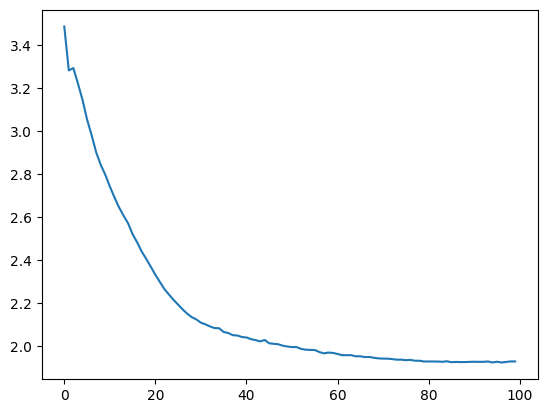

In [28]:
plt.plot(train_loss_history)

In [29]:
df_test_metrics = pd.DataFrame(test_metric_hostory)

In [30]:
df_test_metrics

,acc,blc_acc,cm
0,0.4506,0.4506,"[[717, 23, 117, 20, 27, 2, 16, 4, 62, 12], [19..."
1,0.4492,0.4492,"[[469, 120, 42, 24, 3, 6, 35, 7, 251, 43], [52..."
2,0.5062,0.5062,"[[655, 58, 31, 33, 1, 17, 12, 30, 140, 23], [1..."
3,0.5062,0.5062,"[[460, 85, 40, 10, 12, 3, 7, 34, 249, 100], [2..."
4,0.5387,0.5387,"[[540, 32, 37, 41, 13, 2, 31, 19, 239, 46], [4..."
...,...,...,...
95,0.7682,0.7682,"[[809, 16, 31, 15, 17, 6, 13, 16, 43, 34], [30..."
96,0.7687,0.7687,"[[809, 19, 31, 15, 15, 5, 12, 15, 45, 34], [28..."
97,0.7684,0.7684,"[[809, 19, 31, 15, 15, 5, 12, 15, 45, 34], [28..."
98,0.7683,0.7683,"[[809, 20, 31, 14, 15, 5, 12, 15, 45, 34], [28..."


<Axes: >

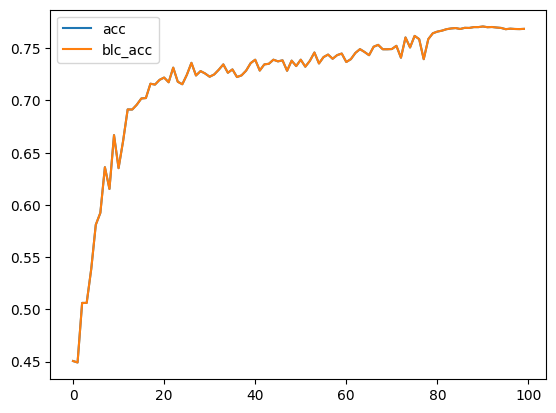

In [31]:
df_test_metrics.filter(like='acc').plot()

In [87]:
index = faiss.IndexFlatL2(256)

In [88]:
with torch.inference_mode():
    for i, batch in enumerate(pb(test_dataloader)):
        batch = batch_to_device(batch, device)
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
            image_features = model.encode_image(batch['pixel_values'])  # (bs, emb_dim)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            index.add(image_features.cpu().numpy().astype(np.float32))

In [ ]:
# faiss.write_index(index, "index.bin")

In [89]:
D, I = index.search(image_features.cpu().numpy().astype(np.float32), 3)

In [90]:
batch.keys()

dict_keys(['pixel_values', 'text_input_ids', 'text_attn_mask', 'label'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.92941177].


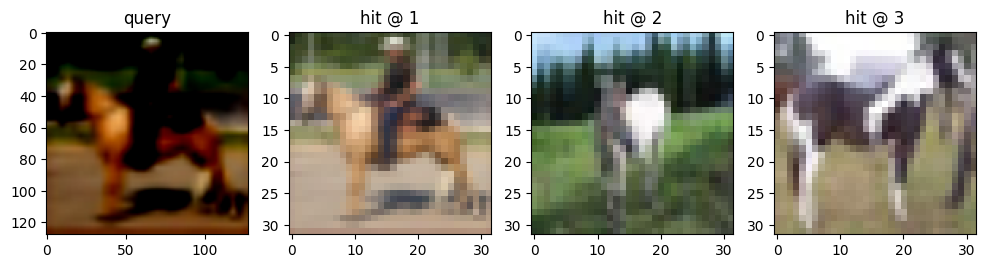

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


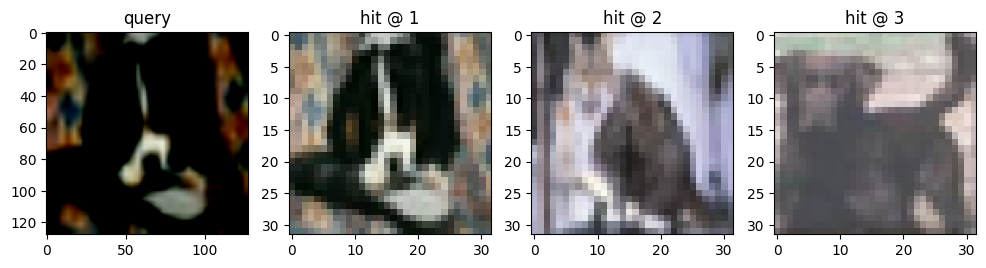

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9843137].


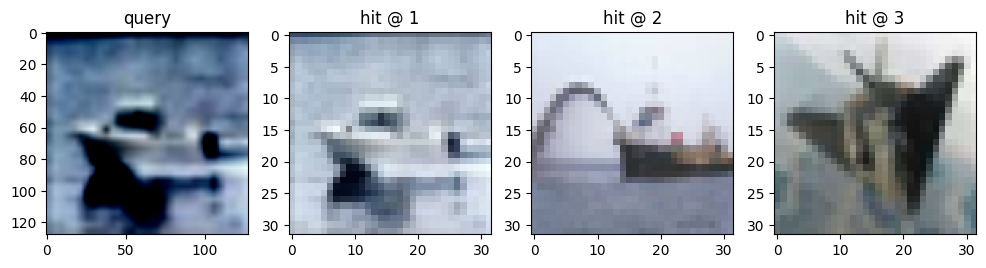

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.8980392].


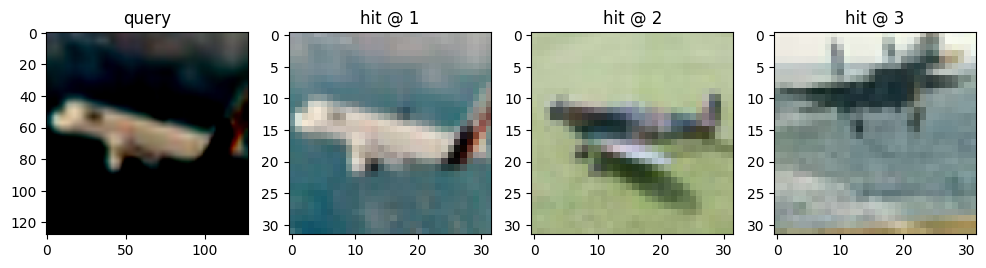

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


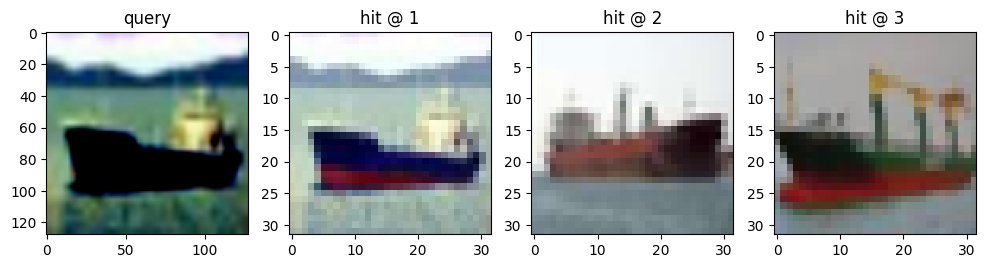

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.84313726].


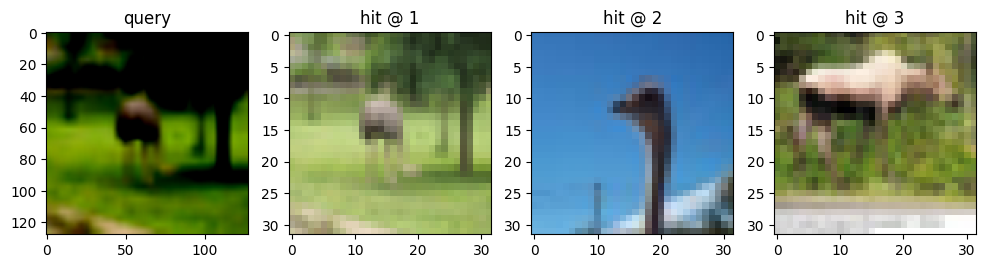

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


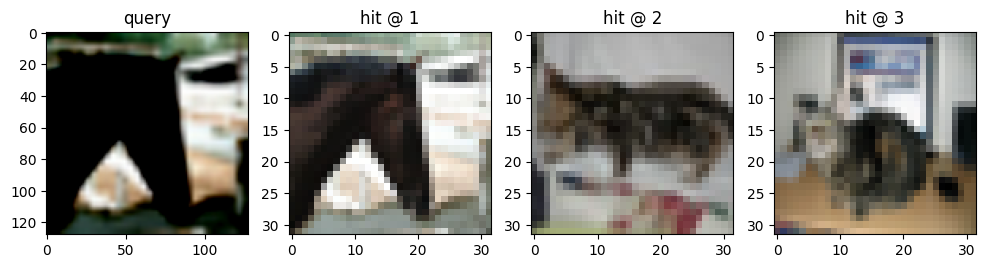

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.99215686].


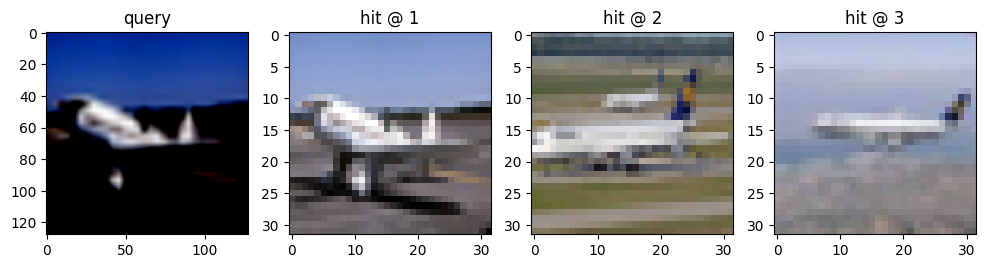

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


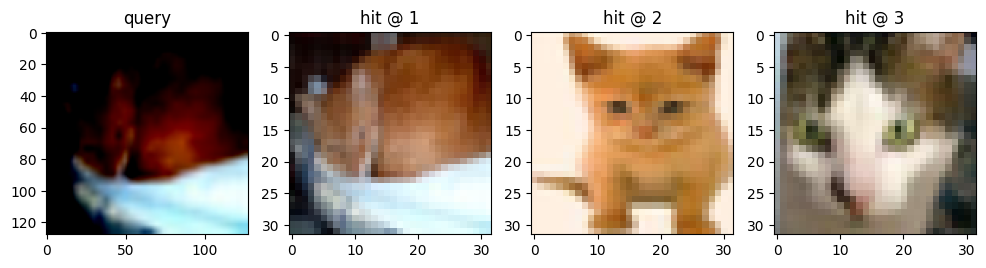

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


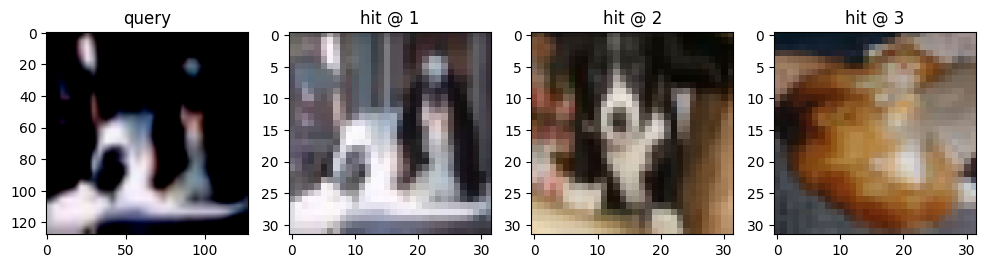

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9843137].


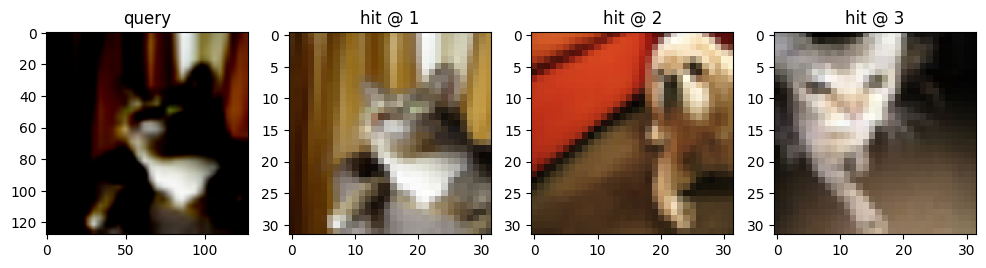

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6392157..1.0].


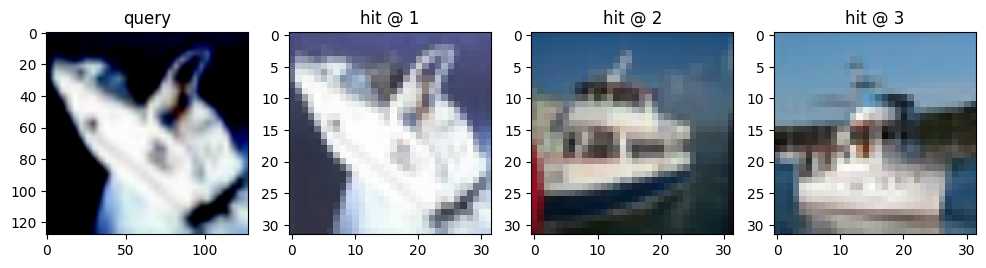

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.7490196].


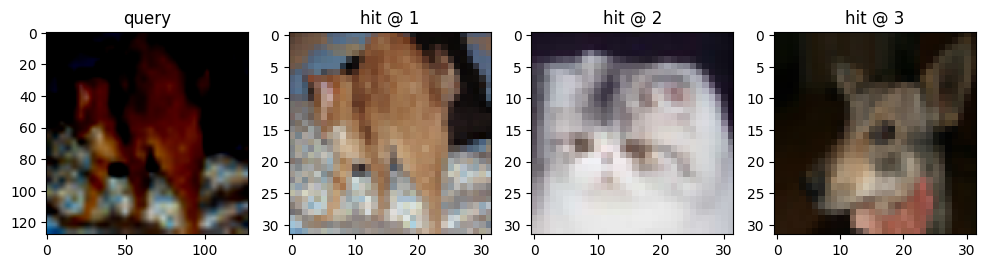

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8745098].


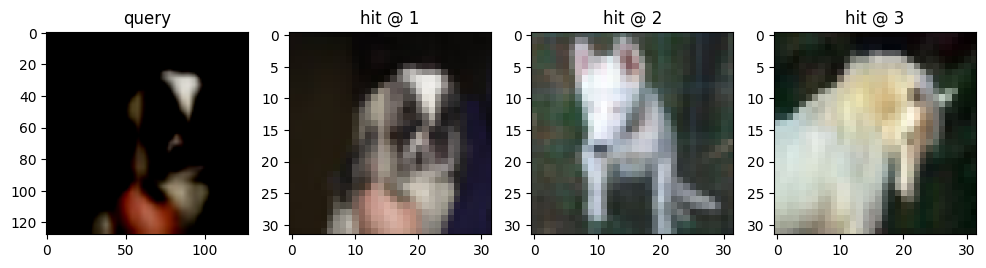

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.96862745].


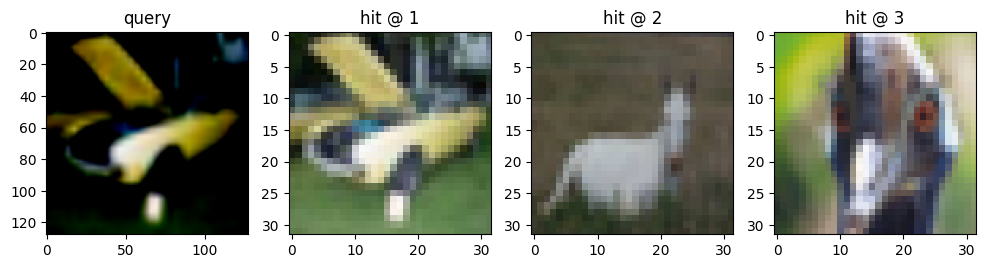

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.9764706].


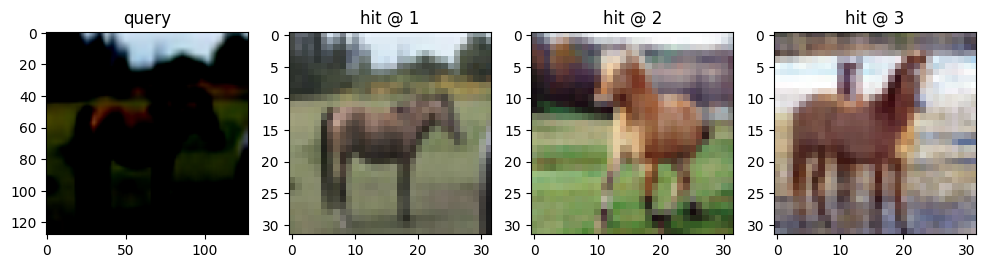

In [91]:
for i in range(I.shape[0]):
    query_image = batch['pixel_values'][i].cpu().permute(1, 2, 0).numpy()
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(3*4, 3))
    axes = axes.flatten()
    axes[0].imshow(query_image)
    axes[0].set_title('query')
    for j in range(3):
        hit_image_index = int(I[i, j])
        hit_image = hf_dataset['test'][hit_image_index]['img']
        axes[j+1].imshow(hit_image)
        axes[j+1].set_title(f'hit @ {j+1}')
    plt.show()

In [102]:
query_texts = ['cat', 'airplane', 'sheep', 'human']
query_texts_input_ids = encode_text(query_texts)['input_ids'].to(device)
with torch.inference_mode():
    query_texts_emb = model.encode_text(query_texts_input_ids)
    query_texts_emb = query_texts_emb / query_texts_emb.norm(dim=-1, keepdim=True)

In [103]:
D, I = index.search(query_texts_emb.cpu().numpy().astype(np.float32), 3)

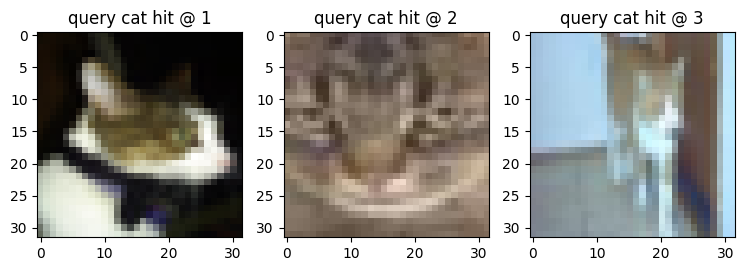

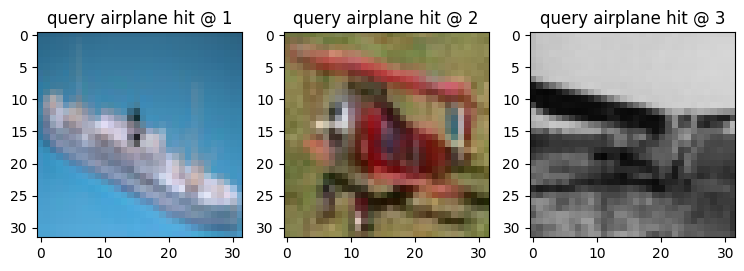

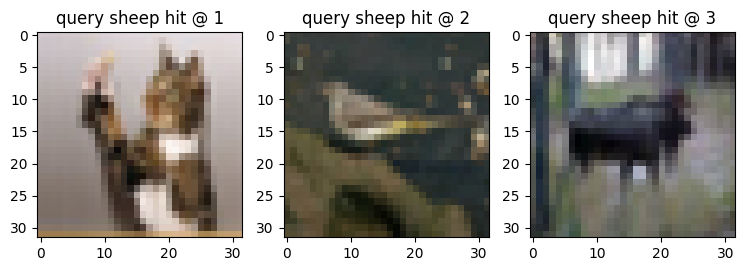

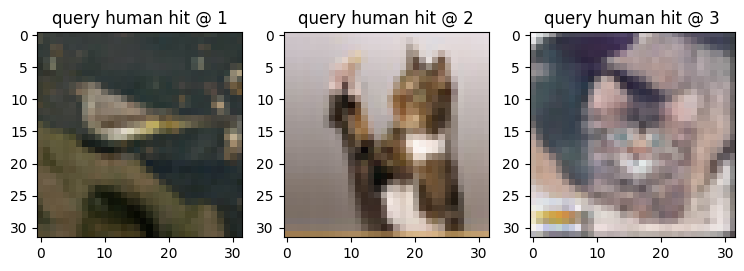

In [104]:
for i, query_text in enumerate(query_texts):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(3*3, 3))
    axes = axes.flatten()
    for j in range(3):
        hit_image_index = int(I[i, j])
        hit_image = hf_dataset['test'][hit_image_index]['img']
        axes[j].imshow(hit_image)
        axes[j].set_title(f'query {query_text} hit @ {j+1}')
    plt.show()